In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plotspectrum(f,Sn):
    plt.figure(0)
    plt.plot(f,np.abs(Sn),linewidth=3,color='b')
    plt.xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    plt.ylabel('Normalized $S_n$ amplitude', fontsize = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.figure(1)
    plt.plot(f,np.angle(Sn),linewidth=3,color='r')
    plt.xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    plt.ylabel('Normalized $S_n$ phase', fontsize = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)

def plotspectrum2(f,Sn):
    fig, ax = plt.subplots()
    ax.plot(f,np.real(Sn),linewidth=1,color='b')
    ax.plot(f,np.imag(Sn),linewidth=1,color='r')
    ax.set_xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    ax.set_ylabel('$(S_n)$', fontsize = 10)

def plotspectrum3(f, Sn, Sn_fd):
    fig, ax = plt.subplots(figsize = (10, 6))
    ax.plot(f,np.real(Sn),linewidth=1,color='b', marker='o', linestyle='-', markersize=4,markerfacecolor='none',label= 'Re($S2^{exp}$)')
    ax.plot(f,np.imag(Sn),linewidth=1,color='r',  marker='o', linestyle='-', markersize=4,markerfacecolor='none', label= 'Im($S2^{exp}$)')
    ax.plot(f,np.real(Sn_fd),linewidth=1,color='b', label= 'Re($S2^{FDM}$)')
    ax.plot(f,np.imag(Sn_fd),linewidth=1,color='r', label= 'Im($S2^{FDM}$)')
    ax.set_xlabel('Frequency ($cm^{-1}$)', fontsize = 10)
    ax.set_ylabel('$(S_n)$', fontsize = 10)
    ax.legend()

def readmaterial(f, filename):
    material = np.genfromtxt(filename, delimiter=',')
    material = np.flipud(material)
    fp = material[:,0]
    eps = np.interp(f, fp, material[:,1]) + 1j*np.interp(f, fp, material[:,2])
    return eps

def readmaterial2(f, filename1, filename2):
    material1 = np.genfromtxt(filename1, delimiter=',')
    f1 = material1[:,0]
    eps1 = np.interp(f,f1, material1[:,1])
    material2 = np.genfromtxt(filename2, delimiter=',')
    f2 = material2[:,0]
    eps2 = np.interp(f,f2,material2[:,1])
    eps = eps1+1j*eps2
    return eps

def finitedipole(w,z,eps,a,L,g):
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    for i in range(len(z)):
        alpha_eff[:,i]=beta*(g-(a+z[i]/L)*np.log(4*L/(4*z[i]+3*a)))/(np.log(4*L/a)-beta*(g-(3*a+4*z[i])/(4*L))*np.log(2*L/(2*z[i]+a)))
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff

def finitedipole_2(w,z,eps,a,L,g):
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    W_0 = z + 1.31*a
    W_1 = z + a/2
    for j in range(len(w)):
        for i in range(len(z)):
            f_0 = (g-(a+z[i]+W_0[i])/(2*L))*np.log(4*L/(a+2*z[i]+2*W_0[i]))/np.log(4*L/a)
            f_1 = (g-(a+z[i]+W_1[i])/(2*L))*np.log(4*L/(a+2*z[i]+2*W_1[i]))/np.log(4*L/a)
            alpha_eff[j,i] = beta[j]*f_0/(1-beta[j]*f_1)
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff

def pointdipole(w,z,eps,a):
    z = z+a
    beta=(eps-1)/(eps+1)
    alpha_eff=np.zeros((len(w),len(z)),dtype=complex)
    alpha = 4*math.pi*a**3
    for j in range(len(w)):
        for i in range(len(z)):
            alpha_eff[j,i] = alpha/(1-alpha*beta[j]/(16*math.pi*z[i]**3))
    alpha_eff=np.transpose(alpha_eff)
    return alpha_eff
    
def demodulate(alpha_eff,t,n):
    fourier=np.cos(n*t)
    fourier=np.repeat(fourier[:,np.newaxis],len(alpha_eff[1,:]),1)
    Sn=np.trapezoid(alpha_eff*fourier,axis=0)
    return Sn

def lorentzeps(w,w0,s,gamma,eps_inf):
    eps=eps_inf+s/(w0**2-w**2-1j*w*gamma)
    return eps

def Sn(w,eps,z,a,L,g,t,n):
    s_samp=demodulate(finitedipole(w,z,eps,a,L,g),t,n)
    s_ref=demodulate(finitedipole(w,z,-10000+10000j,a,L,g),t,n)
    sn=s_samp/s_ref
    return sn

def Sn_2(w,eps,z,a,L,g,t,n):
    s_samp=demodulate(finitedipole_2(w,z,eps,a,L,g),t,n)
    eps_ref = np.ones(1)*(-10000+10000*1j)
    s_ref=demodulate(finitedipole_2([1],z,eps_ref,a,L,g),t,n)
    sn=s_samp/s_ref
    return sn

def Sn_3(w,eps,z,a,t,n):
    s_samp=demodulate(pointdipole(w,z,eps,a),t,n)
    eps_ref = np.ones(1)*(11.7)
    s_ref=demodulate(pointdipole([1],z,eps_ref,a),t,n)
    sn=s_samp/s_ref
    return sn

def farfieldfactor(f,eps):
    import math
    n0 = np.ones(len(f))
    #n1 = np.sqrt(eps)
    n1 = np.sqrt((0.5*np.sqrt(eps*np.conj(eps))+np.real(eps)/2)) + np.sqrt((0.5*np.sqrt(eps*np.conj(eps))-np.real(eps)/2))*1j
    theta = math.pi/3
    cos_theta_t = np.sqrt(1-(n0*np.sin(theta)/n1)**2)
    r = (-n0*cos_theta_t + n1*np.cos(theta))/(n0*cos_theta_t + n1*np.cos(theta))
    FFF = (1+r)*(1+r)
    return FFF

def nk_to_eps(n,k):
    eps1 = n**2-k**2
    eps2 = 2*n*k
    return eps1, eps2


In [2]:
from utils.DataInterface import DataInterface

data_iface = DataInterface()

project_root = data_iface.find_project_root()
chen_data_path = project_root / "data/Chen2021"

main_data_dict = dict()


Project Root: /Users/lugarini/Documents/nano-optics-ml
Data Directory: /Users/lugarini/Documents/nano-optics-ml/data

Contents of the main data directory:
- .DS_Store (File)
- Chen2021 (Dir)
- NanoFTIR (Dir)


In [3]:
data = np.genfromtxt(chen_data_path/'Au_nk.csv', delimiter = ',')
f = data[:,0]
f_Au = np.linspace(1000, 1200,500)
n = np.interp(f_Au, f, data[:,1])
k = np.interp(f_Au, f, data[:,2])
eps1, eps2 = nk_to_eps(n,k)
eps_Au = eps1 + 1j*eps2


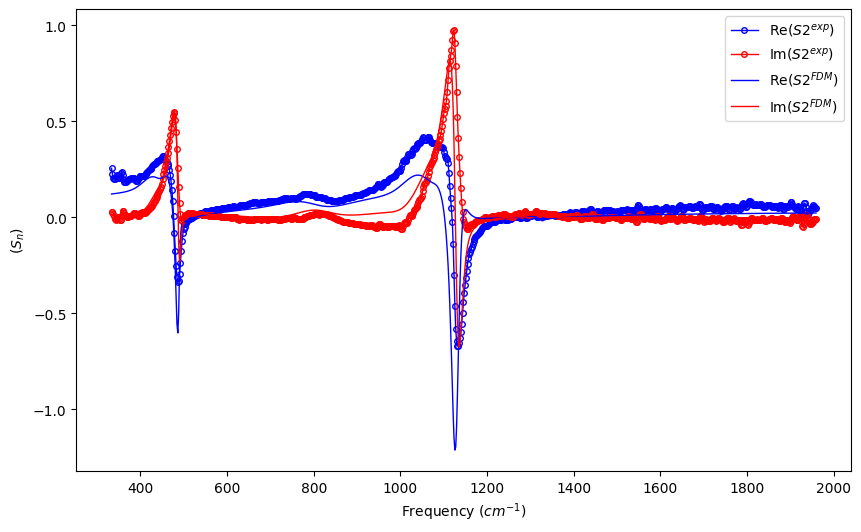

In [4]:
t = np.linspace(0, math.pi,30)
A = 68
h0 = 0
a = 50
L = 500
z = A - A*np.cos(t) + h0
n = 2
g = 0.7*np.exp(0.07*1j)

SiO2 = np.genfromtxt(chen_data_path/'SiO2_eff.csv',delimiter=',')
eps_SiO2 = SiO2[:,0] + 1j*SiO2[:,1]
Sn_SiO2 = SiO2[:,2] + 1j*SiO2[:,3]
f_SiO2 = SiO2[:,4]
Sn_SiO2_cal_fd = 0.25*farfieldfactor(f_SiO2,eps_SiO2)*Sn_2(f_SiO2,eps_SiO2,z,a,L,g,t,n)

SiO2_dict = dict()
SiO2_dict['eps1']  = eps_SiO2.real
SiO2_dict['eps2']  = eps_SiO2.imag
SiO2_dict['sn_exp_real']  = Sn_SiO2.real
SiO2_dict['sn_exp_imag']  = Sn_SiO2.imag
SiO2_dict['f']  = f_SiO2
SiO2_dict['sn_fdm_real']  = Sn_SiO2_cal_fd.real
SiO2_dict['sn_fdm_imag']  = Sn_SiO2_cal_fd.imag

main_data_dict['SiO2'] = SiO2_dict

plotspectrum3(f_SiO2,Sn_SiO2,  Sn_SiO2_cal_fd)

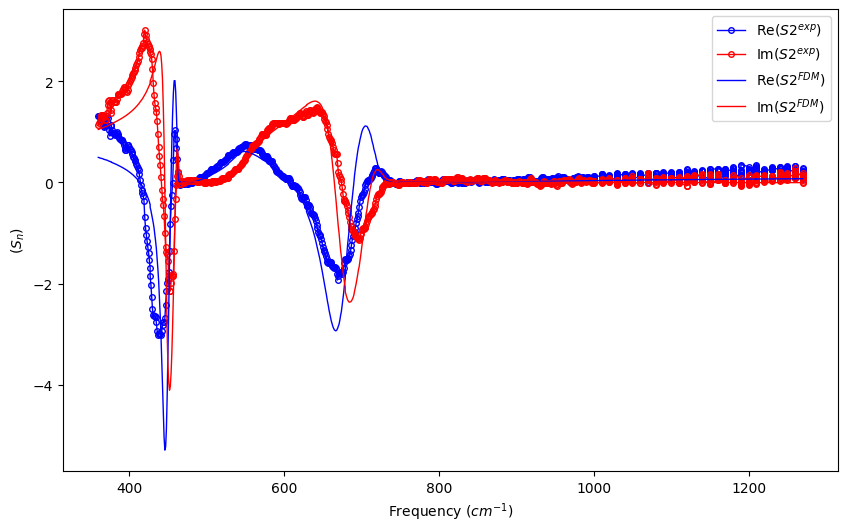

In [5]:
STO = np.genfromtxt(chen_data_path/'STO_eff.csv',delimiter=',')
eps_STO = STO[:,0] + 1j*STO[:,1]
Sn_STO = STO[:,2] + 1j*STO[:,3]
f_STO = STO[:,4]
Sn_STO_cal_fd = 0.25*farfieldfactor(f_STO,eps_STO)*Sn_2(f_STO,eps_STO,z,a,L,g,t,n)

STO_dict = dict()
STO_dict['eps1']  = eps_STO.real
STO_dict['eps2']  = eps_STO.imag
STO_dict['sn_exp_real']  = Sn_STO.real
STO_dict['sn_exp_imag']  = Sn_STO.imag
STO_dict['f']  = f_STO
STO_dict['sn_fdm_real']  = Sn_STO_cal_fd.real
STO_dict['sn_fdm_imag']  = Sn_STO_cal_fd.imag

main_data_dict['STO'] = STO_dict

plotspectrum3(f_STO,Sn_STO,  Sn_STO_cal_fd)

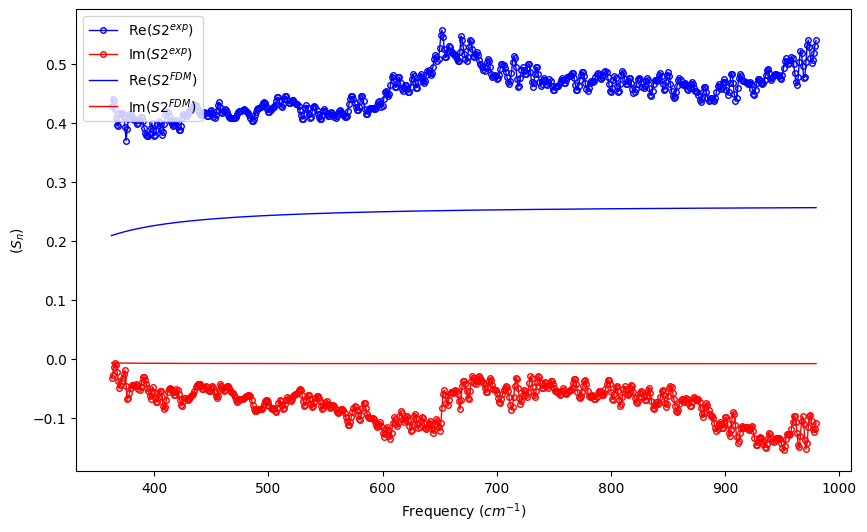

In [6]:
GaAs = np.genfromtxt(chen_data_path/'GaAs_eff.csv',delimiter=',')
eps_GaAs = GaAs[:,0] + 1j*GaAs[:,1]
Sn_GaAs = GaAs[:,2] + 1j*GaAs[:,3]
f_GaAs = GaAs[:,4]
Sn_GaAs_cal_fd = 0.25*farfieldfactor(f_GaAs,eps_GaAs)*Sn_2(f_GaAs,eps_GaAs,z,a,L,g,t,n)

GaAs_dict = dict()
GaAs_dict['eps1']  = eps_GaAs.real
GaAs_dict['eps2']  = eps_GaAs.imag
GaAs_dict['sn_exp_real']  = Sn_GaAs.real
GaAs_dict['sn_exp_imag']  = Sn_GaAs.imag
GaAs_dict['f']  = f_GaAs
GaAs_dict['sn_fdm_real']  = Sn_GaAs_cal_fd.real
GaAs_dict['sn_fdm_imag']  = Sn_GaAs_cal_fd.imag
    
main_data_dict['GaAs'] = GaAs_dict

plotspectrum3(f_GaAs, Sn_GaAs, Sn_GaAs_cal_fd)

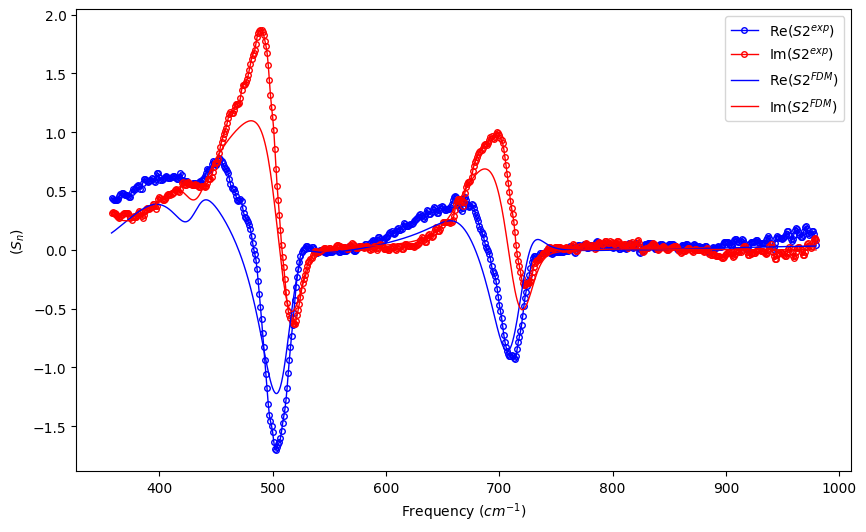

In [7]:

LSAT = np.genfromtxt(chen_data_path/'LSAT_eff.csv',delimiter=',')
eps_LSAT = LSAT[:,0] + 1j*LSAT[:,1]
Sn_LSAT = LSAT[:,2] + 1j*LSAT[:,3]
f_LSAT = LSAT[:,4]
Sn_LSAT_cal_fd = 0.25*farfieldfactor(f_LSAT,eps_LSAT)*Sn_2(f_LSAT,eps_LSAT,z,a,L,g,t,n)

LSAT_dict = dict()
LSAT_dict['eps1']  = eps_LSAT.real
LSAT_dict['eps2']  = eps_LSAT.imag
LSAT_dict['sn_exp_real']  = Sn_LSAT.real
LSAT_dict['sn_exp_imag']  = Sn_LSAT.imag
LSAT_dict['f']  = f_LSAT
LSAT_dict['sn_fdm_real']  = Sn_LSAT_cal_fd.real
LSAT_dict['sn_fdm_imag']  = Sn_LSAT_cal_fd.imag

main_data_dict['LSAT'] = LSAT_dict
plotspectrum3(f_LSAT, Sn_LSAT, Sn_LSAT_cal_fd)

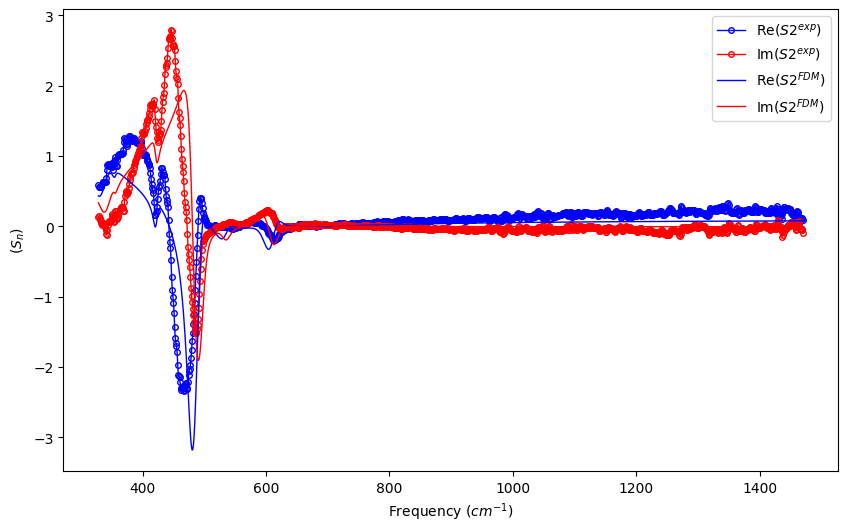

In [8]:
NGO = np.genfromtxt(chen_data_path/'NGO_eff.csv',delimiter=',')
eps_NGO = NGO[:,0] + 1j*NGO[:,1]
Sn_NGO = NGO[:,2] + 1j*NGO[:,3]
f_NGO = NGO[:,4]
Sn_NGO_cal_fd = 0.25*farfieldfactor(f_NGO,eps_NGO)*Sn_2(f_NGO,eps_NGO,z,a,L,g,t,n)

NGO_dict = dict()
NGO_dict['eps1']  = eps_NGO.real
NGO_dict['eps2']  = eps_NGO.imag
NGO_dict['sn_exp_real']  = Sn_NGO.real
NGO_dict['sn_exp_imag']  = Sn_NGO.imag
NGO_dict['f']  = f_NGO
NGO_dict['sn_fdm_real']  = Sn_NGO_cal_fd.real
NGO_dict['sn_fdm_imag']  = Sn_NGO_cal_fd.imag

main_data_dict['NGO'] = NGO_dict
plotspectrum3(f_NGO, Sn_NGO, Sn_NGO_cal_fd)

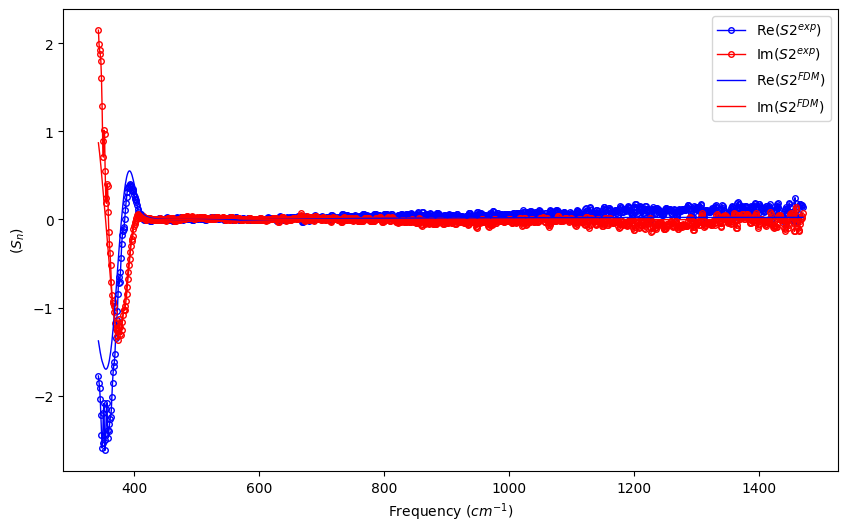

In [9]:

CaF2 = np.genfromtxt(chen_data_path/'CaF2_eff.csv',delimiter=',')
data = np.genfromtxt(chen_data_path/'CaF2_nk.csv', delimiter = ',')
f_CaF2 = CaF2[:,4]
f = data[:,0]
n_CaF2 = np.interp(f_CaF2, f, data[:,1])
k_CaF2 = np.interp(f_CaF2, f, data[:,2])
eps1, eps2 = nk_to_eps(n_CaF2,k_CaF2)
eps_CaF2 = eps1 + 1j*eps2
Sn_CaF2 = CaF2[:,2] + 1j*CaF2[:,3]
Sn_CaF2_cal_fd = 0.25*farfieldfactor(f_CaF2,eps_CaF2)*Sn_2(f_CaF2,eps_CaF2,z,a,L,g,t,n)

CaF2_dict = dict()
CaF2_dict['eps1']  = eps_CaF2.real
CaF2_dict['eps2']  = eps_CaF2.imag
CaF2_dict['sn_exp_real']  = Sn_CaF2.real
CaF2_dict['sn_exp_imag']  = Sn_CaF2.imag
CaF2_dict['f']  = f_CaF2
CaF2_dict['sn_fdm_real']  = Sn_CaF2_cal_fd.real
CaF2_dict['sn_fdm_imag']  = Sn_CaF2_cal_fd.imag

main_data_dict['CaF2'] = CaF2_dict

plotspectrum3(f_CaF2, Sn_CaF2, Sn_CaF2_cal_fd)


In [10]:
import pandas as pd

filtered = True
materials_list = ['STO', 'SiO2','NGO','CaF2', 'LSAT', 'GaAs']

df_list = []
for material, values in main_data_dict.items():
    
    for key in values:
        values[key] = values[key].flatten()  # Ensure all arrays are 1D
    df = pd.DataFrame(values)
    df['material'] = material
    if filtered:
        if material == 'SiO2':
            df = (df[df['f'] < 1400])
        else:
            df = (df[df['f'] < 800])

    df_list.append(df)  

final_df = pd.concat(df_list, ignore_index=True)
final_df['sn_exp'] = final_df['sn_exp_real'] + 1j*final_df['sn_exp_imag']
final_df['sn_fdm'] = final_df['sn_fdm_real'] + 1j*final_df['sn_fdm_imag']
final_df['eps'] = final_df['eps1'] + 1j*final_df['eps2']

final_df['sn_exp_amplitude'] = np.abs(final_df['sn_exp'])
final_df['sn_exp_phase_rad'] = np.arctan2(final_df['sn_exp_imag'], final_df['sn_exp_real'])
final_df['sn_exp_phase_deg'] = np.degrees(final_df['sn_exp_phase_rad'])

final_df['sn_fdm_amplitude'] = np.abs(final_df['sn_fdm'])
final_df['sn_fdm_phase_rad'] = np.arctan2(final_df['sn_fdm_imag'], final_df['sn_fdm_real'])
final_df['sn_fdm_phase_deg'] = np.degrees(final_df['sn_fdm_phase_rad'])

beta = (final_df['eps'] - 1) / (final_df['eps'] + 1)
final_df['beta1'] = np.real(beta)
final_df['beta2'] = np.imag(beta)

final_df

,eps1,eps2,sn_exp_real,sn_exp_imag,f,sn_fdm_real,sn_fdm_imag,material,sn_exp,sn_fdm,eps,sn_exp_amplitude,sn_exp_phase_rad,sn_exp_phase_deg,sn_fdm_amplitude,sn_fdm_phase_rad,sn_fdm_phase_deg,beta1,beta2
0,4.956780,0.647297,0.255885,0.027444,333.370908,0.121982,0.011299,SiO2,0.255885+0.027444j,0.121982+0.011299j,4.956780+0.647297j,0.257352,0.106844,6.121710,0.122504,0.092365,5.292103,0.668166,0.036059
1,4.973697,0.657776,0.226498,0.029745,335.331913,0.122487,0.011562,SiO2,0.226498+0.029745j,0.122487+0.011562j,4.973697+0.657776j,0.228443,0.130579,7.481626,0.123032,0.094111,5.392186,0.669210,0.036424
2,4.991207,0.668238,0.207103,0.019812,337.292918,0.123009,0.011822,SiO2,0.207103+0.019812j,0.123009+0.011822j,4.991207+0.668238j,0.208048,0.095371,5.464348,0.123576,0.095810,5.489505,0.670279,0.036776
3,5.009361,0.678674,0.197882,0.005644,339.253924,0.123548,0.012079,SiO2,0.197882+0.005644j,0.123548+0.012079j,5.009361+0.678674j,0.197963,0.028516,1.633828,0.124138,0.097457,5.583852,0.671377,0.037113
4,5.028215,0.689081,0.198552,-0.008394,341.214929,0.124107,0.012333,SiO2,0.198552-0.008394j,0.124107+0.012333j,5.028215+0.689081j,0.198730,-0.042252,-2.420873,0.124718,0.099048,5.675008,0.672506,0.037436
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2832,1.474810,0.017470,0.007120,0.005281,795.187665,0.013816,-0.001132,CaF2,0.007120+0.005281j,0.013816-0.001132j,1.474810+0.017470j,0.008865,0.638147,36.563130,0.013862,-0.081722,-4.682345,0.191897,0.005704
2833,1.476573,0.017385,0.010149,-0.015904,796.168168,0.013866,-0.001139,CaF2,0.010149-0.015904j,0.013866-0.001139j,1.476573+0.017385j,0.018867,-1.002823,-57.457537,0.013913,-0.081960,-4.695991,0.192472,0.005669
2834,1.478338,0.017300,0.025408,-0.029559,797.148671,0.013917,-0.001146,CaF2,0.025408-0.029559j,0.013917-0.001146j,1.478338+0.017300j,0.038978,-0.860774,-49.318717,0.013964,-0.082197,-4.709536,0.193047,0.005633
2835,1.480103,0.017215,0.043401,-0.030443,798.129173,0.013967,-0.001154,CaF2,0.043401-0.030443j,0.013967-0.001154j,1.480103+0.017215j,0.053013,-0.611680,-35.046700,0.014014,-0.082432,-4.722983,0.193621,0.005597


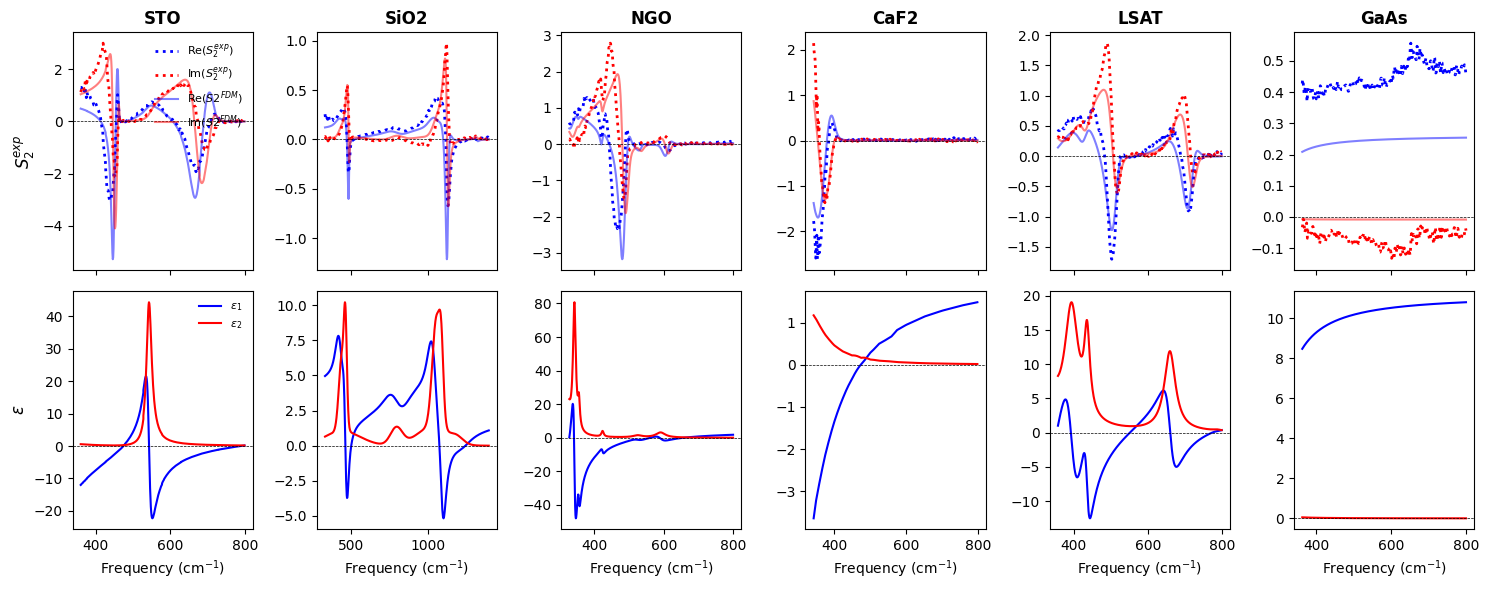

In [11]:
import matplotlib.pyplot as plt

materials = ['STO', 'SiO2', 'NGO', 'CaF2', 'LSAT', 'GaAs']
cols = len(materials)

# Create grid: 2 Rows, 5 Columns
fig, axes = plt.subplots(2, cols, figsize=(15, 6), sharex='col')

# Color Scheme
color_re = 'blue'  # Re(S) and Eps1
color_im = 'red'   # Im(S) and Eps2

for i, mat_name in enumerate(materials):
    if mat_name not in final_df['material'].unique():
        continue
        
    data = final_df.query(f"""material == '{mat_name}'""")
    ax_top = axes[0, i]
    ax_bot = axes[1, i]
    
    # --- TOP ROW: Signal Sn (Experimental) ---
    ax_top.plot(data['f'], np.real(data['sn_exp']), color=color_re, label=r'Re($S_2^{exp}$)', linestyle='dotted', linewidth=2)
    ax_top.plot(data['f'], np.imag(data['sn_exp']), color=color_im, label=r'Im($S_2^{exp}$)', linestyle='dotted', linewidth=2)
    # ax[0, i].set_title(f'{material}', )
    # ax[0,i].plot(f_material, Sn_material.real, label= 'Re($S2^{exp}$)',color='b', linestyle='dotted', linewidth=2)
    # ax[0,i].plot(f_material, Sn_material.imag, label= 'Im($S2^{exp}$)', color='r', linestyle='dotted', linewidth=2)

    ax_top.plot(data['f'], np.real(data['sn_fdm']), label= 'Re($S2^{FDM}$)',color='b', alpha=0.5)
    ax_top.plot(data['f'], np.imag(data['sn_fdm']), label= 'Im($S2^{FDM}$)', color='r', alpha=0.5)
    
    # Titles and Formatting
    ax_top.set_title(mat_name, fontweight='bold', fontsize=12)
    ax_top.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    # Only show Y-label for the first column
    if i == 0:
        ax_top.set_ylabel(r'$S_2^{exp}$', fontsize=12)
    
    # Add legend only to the first plot to avoid clutter
    if i == 0:
        ax_top.legend(frameon=False, fontsize=8, loc='upper right')

    # --- BOTTOM ROW: Epsilon (Dielectric Function) ---
    ax_bot.plot(data['f'], np.real(data['eps']), color=color_re, label=r'$\epsilon_1$')
    ax_bot.plot(data['f'], np.imag(data['eps']), color=color_im, label=r'$\epsilon_2$')
    
    ax_bot.set_xlabel(r'Frequency (cm$^{-1}$)')
    ax_bot.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    if i == 0:
        ax_bot.set_ylabel(r'$\epsilon$', fontsize=12)
        ax_bot.legend(frameon=False, fontsize=8, loc='upper right')

plt.tight_layout()

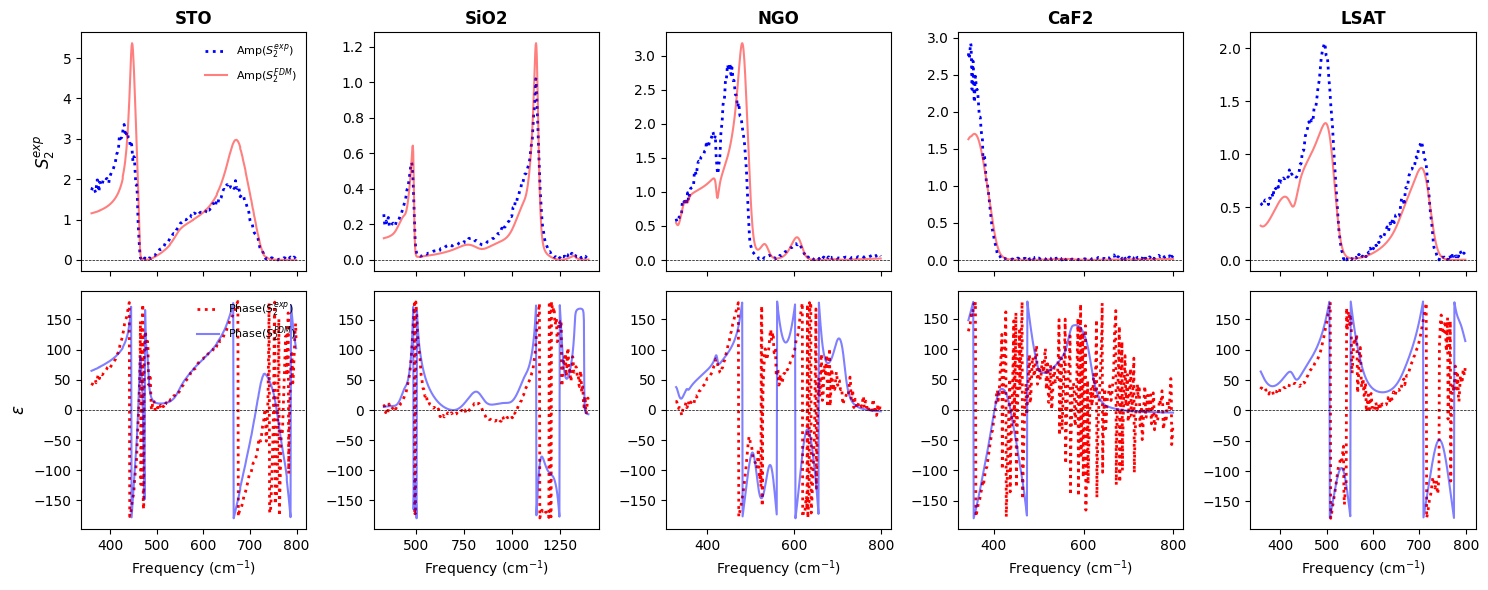

In [12]:
materials = ['STO', 'SiO2', 'NGO', 'CaF2', 'LSAT']
cols = len(materials)

# Create grid: 2 Rows, 5 Columns
fig, axes = plt.subplots(2, cols, figsize=(15, 6), sharex='col')

# Color Scheme
color_re = 'blue'  # Re(S) and Eps1
color_im = 'red'   # Im(S) and Eps2

for i, mat_name in enumerate(materials):
    if mat_name not in final_df['material'].unique():
        continue
        
    data = final_df.query(f"""material == '{mat_name}'""")
    ax_top = axes[0, i]
    ax_bot = axes[1, i]
    
    # --- TOP ROW: Signal Sn (Experimental) ---
    ax_top.plot(data['f'], np.abs(data['sn_exp']), color=color_re, label=r'Amp($S_2^{exp}$)', linestyle='dotted', linewidth=2)
    ax_top.plot(data['f'], np.abs(data['sn_fdm']), color=color_im, label=r'Amp($S_2^{FDM}$)', linestyle='solid', alpha=0.5)
    
    # Titles and Formatting
    ax_top.set_title(mat_name, fontweight='bold', fontsize=12)
    ax_top.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    # Only show Y-label for the first column
    if i == 0:
        ax_top.set_ylabel(r'$S_2^{exp}$', fontsize=12)
    
    # Add legend only to the first plot to avoid clutter
    if i == 0:
        ax_top.legend(frameon=False, fontsize=8, loc='upper right')

    ax_bot.plot(data['f'], data['sn_exp_phase_deg'], color=color_im, label=r'Phase($S_2^{exp}$)', linestyle='dotted', linewidth=2)
    ax_bot.plot(data['f'], data['sn_fdm_phase_deg'], color=color_re, label=r'Phase($S_2^{FDM}$)', linestyle='solid', alpha=0.5)
    ax_bot.set_xlabel(r'Frequency (cm$^{-1}$)')
    ax_bot.axhline(0, color='black', linewidth=0.5, linestyle='--')
    
    if i == 0:
        ax_bot.set_ylabel(r'$\epsilon$', fontsize=12)
        ax_bot.legend(frameon=False, fontsize=8, loc='upper right')

plt.tight_layout()

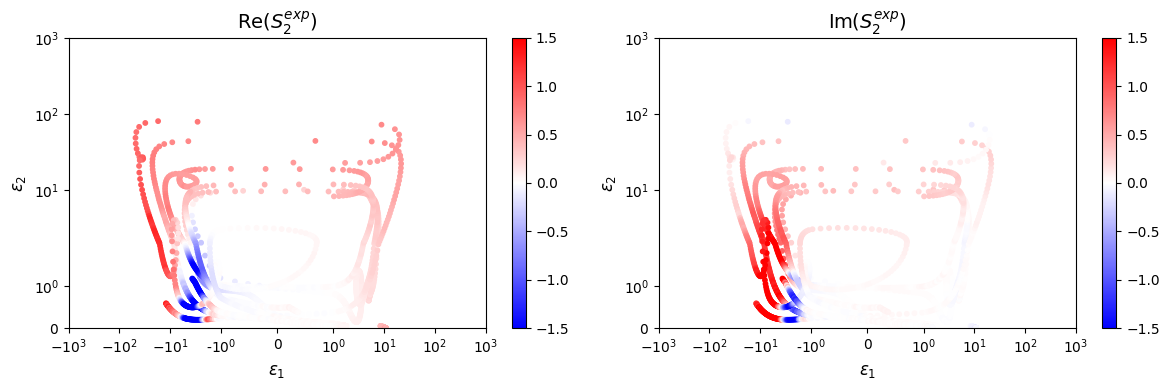

In [13]:
import matplotlib.colors as mcolors

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

norm = mcolors.CenteredNorm(vcenter=0, halfrange = 1.5)  
sc1 = axes[0].scatter(final_df['eps1'], final_df['eps2'], 
                      c=final_df['sn_exp_real'], cmap='bwr', norm=norm, marker='o', s=10,  label= 'Re($S2^{exp}$)')
axes[0].set_xlabel(r'$\epsilon_1$', fontsize=12)
axes[0].set_ylabel(r'$\epsilon_2$', fontsize=12)
axes[0].set_title(r'Re($S^{exp}_2$)', fontsize=14)

axes[0].set_xscale('symlog', linthresh=1)  # Symmetric log scale
axes[0].set_xticks([-10**3, -10**2, -10, -1, 0, 1, 10, 10**2, 10**3])  # Custom ticks
axes[0].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'-$10^0$','0', r'$10^0$',r'$10^1$', r'$10^2$', r'$10^3$'])

axes[0].set_yscale('symlog', linthresh=2)  # Symmetric log scale
axes[0].set_yticks([0, 1,10, 10**2, 10**3])  # Custom ticks
axes[0].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[0].set_ylim(bottom=0)

cb1 = plt.colorbar(sc1, ax=axes[0])

sc2 = axes[1].scatter(final_df['eps1'], final_df['eps2'], 
                      c=final_df['sn_exp_imag'], cmap='bwr', norm = norm, marker='o', s=10,  label= 'Im($S2^{exp}$)')
axes[1].set_xlabel(r'$\epsilon_1$', fontsize=12)
axes[1].set_ylabel(r'$\epsilon_2$', fontsize=12)
axes[1].set_title(r'Im($S^{exp}_2$)', fontsize=14)

axes[1].set_xscale('symlog', linthresh=1)  # Symmetric log scale
axes[1].set_xticks([-10**3, -10**2, -10, -1, 0, 1, 10, 10**2, 10**3])  # Custom ticks
axes[1].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'-$10^0$','0', r'$10^0$',r'$10^1$', r'$10^2$', r'$10^3$'])

axes[1].set_yscale('symlog', linthresh=2)  # Symmetric log scale
axes[1].set_yticks([0, 1,10, 10**2, 10**3])  # Custom ticks
axes[1].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
axes[1].set_ylim(bottom=0)
cb2 = plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()
plt.show()

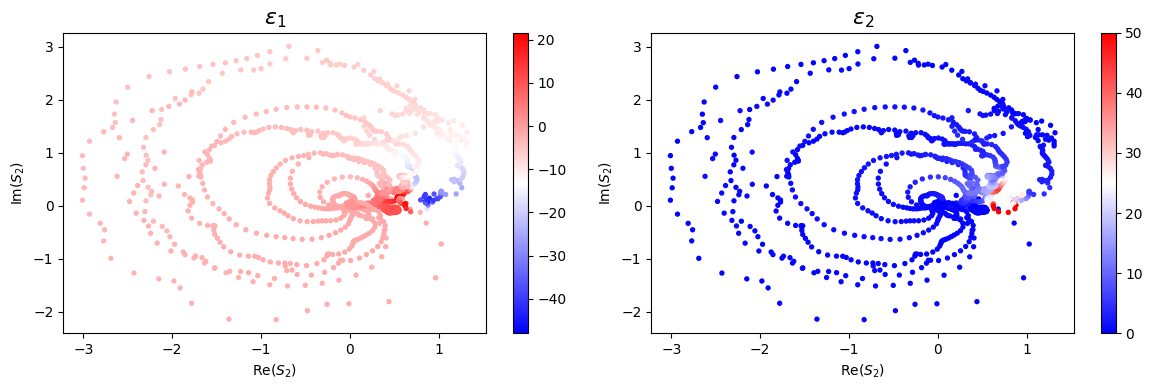

In [14]:
# Create a figure with two subplots.
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

sc1 = axes[0].scatter(final_df['sn_exp_real'], final_df['sn_exp_imag'], 
                      c=final_df['eps1'], cmap='bwr', marker='o', s = 8)
axes[0].set_xlabel(r'Re($S_2$)') 
axes[0].set_ylabel(r'Im($S_2$)') 
axes[0].set_title(r'$\epsilon_1$', fontsize=16)
cb1 = plt.colorbar(sc1, ax=axes[0])

norm = mcolors.CenteredNorm(vcenter=25, halfrange = 25)  
sc2 = axes[1].scatter(final_df['sn_exp_real'], final_df['sn_exp_imag'], 
                      c=final_df['eps2'], cmap='bwr', marker='o', norm=norm, s=8)
axes[1].set_xlabel(r'Re($S_2$)') 
axes[1].set_ylabel(r'Im($S_2$)') 
axes[1].set_title(r'$\epsilon_2$', fontsize=16)
cb2 = plt.colorbar(sc2, ax=axes[1])

plt.tight_layout()
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size=8, num_hidden_layers=3, output_size=2):
        super(NeuralNet, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Sigmoid()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class HybridNeuralNet(nn.Module):
    def __init__(self, input_size=4, hidden_size=8, num_hidden_layers=3, output_size=2):
        super(HybridNeuralNet, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.Sigmoid()]
        for _ in range(num_hidden_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.Sigmoid())
        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        fdm = x[:, 2:]  # Extract Sn_fdm_real and Sn_fdm_imag
        correction = self.network(x)
        return fdm + correction


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

df = final_df.copy()

lsat_df = df[df['material'] == 'LSAT'].copy()

df = df.loc[(df['material'] != 'LSAT')].reset_index(drop=True)

X_nn = df[['beta1', 'beta2']].values.astype(np.float32)
X_hnn = df[['beta1', 'beta2','sn_fdm_real','sn_fdm_imag']].values.astype(np.float32)
y = df[['sn_exp_real', 'sn_exp_imag']].values.astype(np.float32)

materials = df['material'].values

use_lsat_as_test = True
if use_lsat_as_test:
    X_train_nn = X_nn
    X_train_hnn = X_hnn
    y_train = y

    X_test_nn = lsat_df[['beta1', 'beta2']].values.astype(np.float32)
    X_test_hnn = lsat_df[['beta1', 'beta2','sn_fdm_real','sn_fdm_imag']].values.astype(np.float32)
    y_test = lsat_df[['sn_exp_real', 'sn_exp_imag']].values.astype(np.float32)
else:
    X_train_nn, X_test_nn, y_train, y_test, _, _ = train_test_split(
        X_nn, y, materials, test_size=0.2, random_state=42)
    X_train_hnn, X_test_hnn, y_train, y_test, _, _ = train_test_split(
        X_hnn, y, materials, test_size=0.2, random_state=42)

scaler_X_nn = StandardScaler()
scaler_X_hnn = StandardScaler()
scaler_y = StandardScaler()

X_train_nn_scaled = scaler_X_nn.fit_transform(X_train_nn)
X_test_nn_scaled = scaler_X_nn.transform(X_test_nn)

X_train_hnn_scaled = scaler_X_hnn.fit_transform(X_train_hnn)
X_test_hnn_scaled = scaler_X_hnn.transform(X_test_hnn)

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

class MaterialDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
nn_train_dataset = MaterialDataset(X_train_nn_scaled, y_train_scaled)
nn_test_dataset = MaterialDataset(X_test_nn_scaled, y_test_scaled)

hnn_train_dataset = MaterialDataset(X_train_hnn_scaled, y_train_scaled)
hnn_test_dataset = MaterialDataset(X_test_hnn_scaled, y_test_scaled)


In [17]:
import copy

def train_model(
        model, 
        train_loader, 
        test_loader, 
        optimizer, 
        criterion, 
        num_epochs, 
        device, 
        patience=50000
    ):
    model.train()
    history = {}

    best_loss = float('inf')
    best_model_state = None
    epochs_no_improve = 0

    for epoch in range(num_epochs):
        running_loss = 0.0

        model.train()
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(train_loader.dataset)
        
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                test_loss += loss.item() * inputs.size(0)
        test_loss /= len(test_loader.dataset)
        history[epoch+1] = {'loss': epoch_loss, 'test_loss': test_loss}
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Test Loss: {test_loss:.4f}")
        
        if patience is not None:
            if test_loss < best_loss:
                # Found new best model; save it
                best_loss = test_loss
                best_model_state = copy.deepcopy(model.state_dict())
                epochs_no_improve = 0
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve == patience:
                print(f"Early stopping on epoch {epoch+1} with best test loss {best_loss:.4f}.")
                break

    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return history

def evaluate_model(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
    avg_loss = total_loss / len(test_loader.dataset)
    print(f"Final Test Loss: {avg_loss:.4f}")
    return avg_loss

def save_model(model, path):
    """Save the trained model."""
    torch.save(model.state_dict(), path)

def load_model(model, path, device):
    """Load a saved model."""
    model.load_state_dict(torch.load(path, map_location=device))
    return model

In [35]:

device = torch.device('cpu')

print(f"Using computational device: {device}")

batch_size = 16

hidden_size = 16
learning_rate = 0.001
weight_decay = 1e-5
num_epochs = 4000

nn_train_loader = DataLoader(nn_train_dataset, batch_size=batch_size, shuffle=True)
nn_test_loader = DataLoader(nn_test_dataset, batch_size=batch_size, shuffle=False)

hnn_train_loader = DataLoader(hnn_train_dataset, batch_size=batch_size, shuffle=True)
hnn_test_loader = DataLoader(hnn_test_dataset, batch_size=batch_size, shuffle=False)

nn_model = NeuralNet(input_size=X_train_nn.shape[1], hidden_size=hidden_size).to(device)
criterion = nn.MSELoss()
optimizer_nn = optim.Adam(
    nn_model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

hnn_model = HybridNeuralNet(input_size=X_train_hnn.shape[1], hidden_size=hidden_size).to(device)
optimizer_hnn = optim.Adam(
    hnn_model.parameters(), 
    lr=learning_rate, 
    weight_decay=weight_decay
)

Using computational device: cpu


In [36]:
train_history_nn = train_model(
    nn_model, 
    nn_train_loader, 
    nn_test_loader, 
    optimizer_nn, 
    criterion, 
    num_epochs, 
    device, 
    patience=50000
)
evaluate_model(nn_model, nn_test_loader, criterion, device)
y_pred_nn_scaled = nn_model(torch.tensor(X_test_nn_scaled, dtype=torch.float32).to(device)).cpu().detach().numpy()
y_pred_nn = scaler_y.inverse_transform(y_pred_nn_scaled)


Epoch 100/4000, Loss: 0.1273, Test Loss: 0.1051
Epoch 200/4000, Loss: 0.1111, Test Loss: 0.1161
Epoch 300/4000, Loss: 0.0994, Test Loss: 0.1137
Epoch 400/4000, Loss: 0.0856, Test Loss: 0.1107
Epoch 500/4000, Loss: 0.0719, Test Loss: 0.0827
Epoch 600/4000, Loss: 0.0606, Test Loss: 0.0877
Epoch 700/4000, Loss: 0.0526, Test Loss: 0.0964
Epoch 800/4000, Loss: 0.0473, Test Loss: 0.0969
Epoch 900/4000, Loss: 0.0438, Test Loss: 0.1117
Epoch 1000/4000, Loss: 0.0401, Test Loss: 0.1234
Epoch 1100/4000, Loss: 0.0395, Test Loss: 0.1227
Epoch 1200/4000, Loss: 0.0346, Test Loss: 0.1286
Epoch 1300/4000, Loss: 0.0324, Test Loss: 0.1249
Epoch 1400/4000, Loss: 0.0300, Test Loss: 0.1342
Epoch 1500/4000, Loss: 0.0292, Test Loss: 0.1412
Epoch 1600/4000, Loss: 0.0266, Test Loss: 0.1438
Epoch 1700/4000, Loss: 0.0242, Test Loss: 0.1517
Epoch 1800/4000, Loss: 0.0220, Test Loss: 0.1406
Epoch 1900/4000, Loss: 0.0209, Test Loss: 0.1448
Epoch 2000/4000, Loss: 0.0197, Test Loss: 0.1494
Epoch 2100/4000, Loss: 0.0188

In [37]:

train_history_hnn = train_model(
    hnn_model, 
    hnn_train_loader, 
    hnn_test_loader, 
    optimizer_hnn, 
    criterion, 
    num_epochs, 
    device, 
    patience=50000
)
evaluate_model(hnn_model, hnn_test_loader, criterion, device)
y_pred_hnn_scaled = hnn_model(torch.tensor(X_test_hnn_scaled, dtype=torch.float32).to(device)).cpu().detach().numpy()
y_pred_hnn = scaler_y.inverse_transform(y_pred_hnn_scaled)

Epoch 100/4000, Loss: 0.1438, Test Loss: 0.0998
Epoch 200/4000, Loss: 0.0950, Test Loss: 0.1070
Epoch 300/4000, Loss: 0.0653, Test Loss: 0.0772
Epoch 400/4000, Loss: 0.0552, Test Loss: 0.1242
Epoch 500/4000, Loss: 0.0492, Test Loss: 0.1025
Epoch 600/4000, Loss: 0.0443, Test Loss: 0.1118
Epoch 700/4000, Loss: 0.0412, Test Loss: 0.1180
Epoch 800/4000, Loss: 0.0383, Test Loss: 0.1335
Epoch 900/4000, Loss: 0.0354, Test Loss: 0.1254
Epoch 1000/4000, Loss: 0.0328, Test Loss: 0.1271
Epoch 1100/4000, Loss: 0.0308, Test Loss: 0.1310
Epoch 1200/4000, Loss: 0.0283, Test Loss: 0.1353
Epoch 1300/4000, Loss: 0.0275, Test Loss: 0.1378
Epoch 1400/4000, Loss: 0.0258, Test Loss: 0.1421
Epoch 1500/4000, Loss: 0.0247, Test Loss: 0.1477
Epoch 1600/4000, Loss: 0.0228, Test Loss: 0.1390
Epoch 1700/4000, Loss: 0.0225, Test Loss: 0.1614
Epoch 1800/4000, Loss: 0.0210, Test Loss: 0.1592
Epoch 1900/4000, Loss: 0.0206, Test Loss: 0.1551
Epoch 2000/4000, Loss: 0.0198, Test Loss: 0.1560
Epoch 2100/4000, Loss: 0.0189

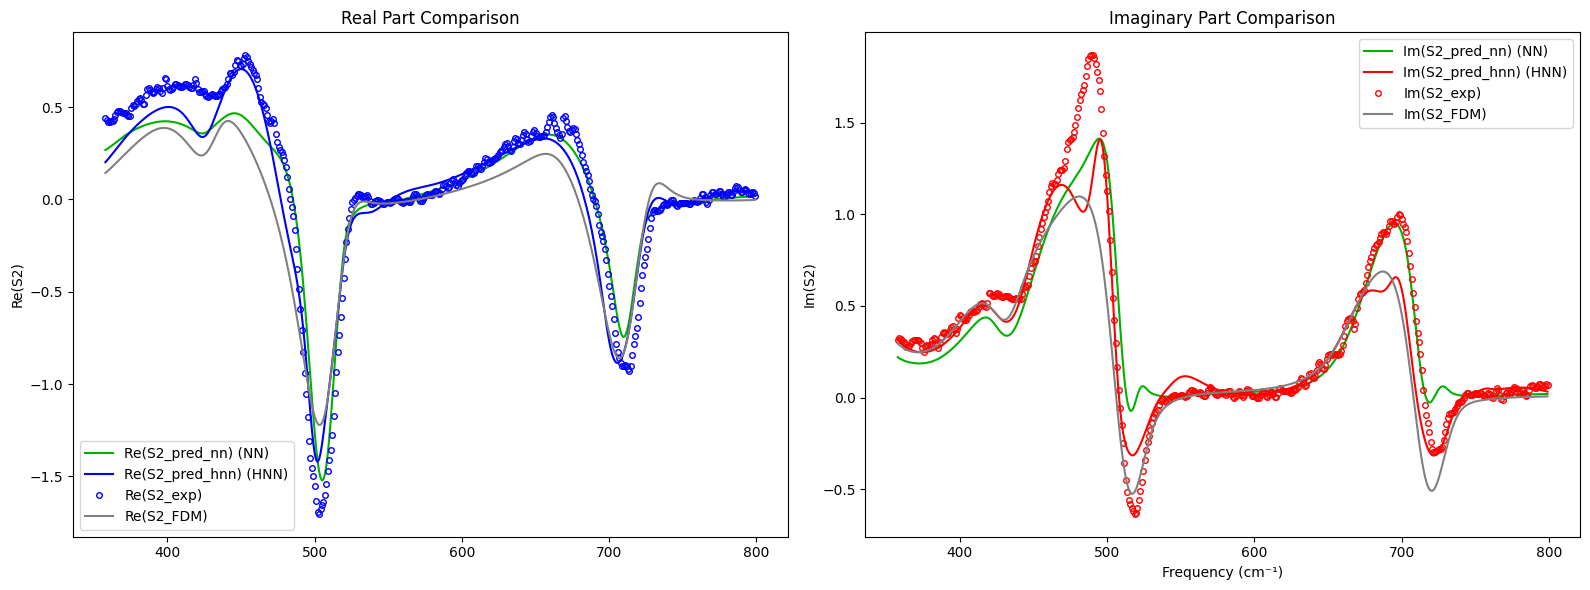

In [38]:
# ---------------------------
# LSAT Test Predictions and Plotting
# ---------------------------

test_df = final_df.query("material == 'LSAT'")[['beta1', 'beta2', 'sn_fdm_real', 'sn_fdm_imag', 'f', 'sn_exp_real', 'sn_exp_imag']].copy()

# NN predictions on LSAT (using beta1 and beta2)
X_test_ls_nn = scaler_X_nn.transform(test_df[['beta1', 'beta2']].values.astype(np.float32))
X_test_ls_nn_tensor = torch.from_numpy(X_test_ls_nn).float()
nn_ls_pred_scaled = nn_model(X_test_ls_nn_tensor.to(device)).cpu().detach().numpy()
nn_ls_pred = scaler_y.inverse_transform(nn_ls_pred_scaled)
nn_output_df = pd.DataFrame(nn_ls_pred, columns=['S2_pred_nn_real', 'S2_pred_nn_imag'])

# HNN predictions on LSAT (using beta1, beta2, Sn_fdm_real, Sn_fdm_imag)
X_test_ls_hnn = scaler_X_hnn.transform(test_df[['beta1', 'beta2', 'sn_fdm_real', 'sn_fdm_imag']].values.astype(np.float32))
X_test_ls_hnn_tensor = torch.from_numpy(X_test_ls_hnn).float()
hnn_ls_pred_scaled = hnn_model(X_test_ls_hnn_tensor.to(device)).cpu().detach().numpy()
hnn_ls_pred = scaler_y.inverse_transform(hnn_ls_pred_scaled)
hnn_output_df = pd.DataFrame(hnn_ls_pred, columns=['S2_pred_hnn_real', 'S2_pred_hnn_imag'])

# Combine predictions with the test data for plotting
output_df = pd.concat([test_df.reset_index(drop=True), nn_output_df, hnn_output_df], axis=1)

fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

axes[0].plot(output_df['f'], output_df['S2_pred_nn_real'], 
             label='Re(S2_pred_nn) (NN)', linestyle='-', markersize=4, color='#00B200')
axes[0].plot(output_df['f'], output_df['S2_pred_hnn_real'], 
             label='Re(S2_pred_hnn) (HNN)', linestyle='-', markersize=4, color='blue')
axes[0].plot(output_df['f'], output_df['sn_exp_real'], 
             label='Re(S2_exp)', marker='o', linestyle='', markersize=4,
             markerfacecolor='none', markeredgecolor='blue')
axes[0].plot(output_df['f'], output_df['sn_fdm_real'], 
             label='Re(S2_FDM)', linestyle='-', markersize=4, color='gray')
axes[0].set_ylabel('Re(S2)')
axes[0].set_title('Real Part Comparison')
axes[0].legend()

axes[1].plot(output_df['f'], output_df['S2_pred_nn_imag'], 
             label='Im(S2_pred_nn) (NN)', linestyle='-', markersize=4, color='#00B200')
axes[1].plot(output_df['f'], output_df['S2_pred_hnn_imag'], 
             label='Im(S2_pred_hnn) (HNN)', linestyle='-', markersize=4, color='red')
axes[1].plot(output_df['f'], output_df['sn_exp_imag'], 
             label='Im(S2_exp)', marker='o', linestyle='', markersize=4,
             markerfacecolor='none', markeredgecolor='red')
axes[1].plot(output_df['f'], output_df['sn_fdm_imag'], 
             label='Im(S2_FDM)', linestyle='-', color='gray')
axes[1].set_ylabel('Im(S2)')
axes[1].set_title('Imaginary Part Comparison')
axes[1].legend()
axes[1].set_xlabel('Frequency (cm⁻¹)')

plt.tight_layout()
plt.show()


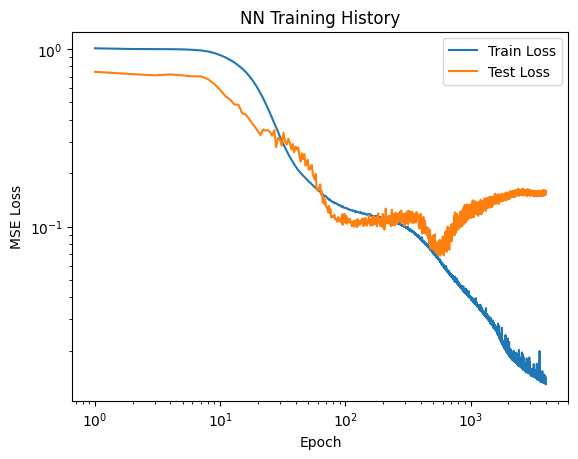

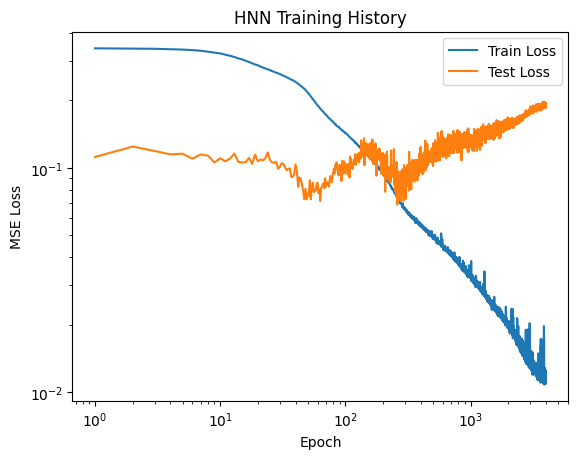

In [39]:
def plot_training_history(history, title_prefix='Model'):
    """Plots train vs test loss given a history dictionary from train_model."""
    # Extract epochs (keys) and their corresponding losses
    epochs = list(history.keys())
    train_loss = [history[e]['loss'] for e in epochs]
    test_loss = [history[e]['test_loss'] for e in epochs]

    plt.figure()  # (1) each chart on its own distinct plot
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss') 
    plt.xscale('log')
    plt.yscale('log')
    plt.title(f'{title_prefix} Training History')
    plt.legend()
    plt.show()

plot_training_history(train_history_nn, title_prefix='NN')
plot_training_history(train_history_hnn, title_prefix='HNN')

In [40]:
def generate_symlog_like_epsilon(num_points=200, linthresh=1):
    """
    Generate a piecewise 'symlog' style array on [-1e3, 1e3].
    'linthresh' sets the half-range of the linear region around 0.
    """
    # 1) Log-spaced negative portion (from -1e3 to -linthresh)
    neg_part = -np.logspace(np.log10(linthresh), np.log10(1e3), num_points//4)[::-1]
    
    # 2) Linear portion around zero ([-linthresh, linthresh])
    lin_part = np.linspace(-linthresh, linthresh, num_points//2)
    
    # 3) Log-spaced positive portion ([linthresh, 1e3])
    pos_part = np.logspace(np.log10(linthresh), np.log10(1e3), num_points//4)

    eps1_symlog = np.concatenate([neg_part, lin_part, pos_part])
    return eps1_symlog

def generate_epsilon_grid(eps1_min, eps1_max, eps2_min, eps2_max, num_points=200):
    """
    Create a 2D grid of complex eps values:
      - Real(eps) in [eps1_min, eps1_max]
      - Imag(eps) in [eps2_min, eps2_max]
    Returns (eps_grid, Eps1, Eps2)
    """

    eps1 = generate_symlog_like_epsilon(num_points, linthresh=1)
    eps2 = generate_symlog_like_epsilon(num_points, linthresh=2)

    Eps1, Eps2 = np.meshgrid(eps1, eps2)
    eps_grid = Eps1 + 1j * Eps2
    return eps_grid, Eps1, Eps2

def compute_beta(eps):
    """Compute beta = (eps - 1)/(eps + 1)."""
    return (eps - 1) / (eps + 1)

import numpy as np
import math

def get_fdm_prediction(eps_array, freq=500, a=50, L=500, A=68, h0=0, g=0.7*np.exp(0.07*1j), n=2, n_points=30):
    """
    Compute the baseline FDM prediction for each element in eps_array
    at a single frequency (freq).
    
    Parameters
    ----------
    eps_array : array-like of complex
        The array of complex permittivities for which we want the baseline FDM.
    freq : float, optional
        The frequency at which we compute the FDM (in cm^-1).
    a, L, A, h0, g, n, n_points : various, optional
        Physical parameters used in your FDM code. The defaults are based on
        your example scripts.
    """
    # Create the tapping motion array
    t = np.linspace(0, math.pi, n_points)
    z = A - A*np.cos(t) + h0
    
    # Helper function to compute the FDM for a single eps
    def fdm_for_one_eps(eps):
        # farfieldfactor(freq, eps) expects freq to be an array or at least 1D
        # but we can pass a scalar if you updated farfieldfactor to handle that
        # ff = farfieldfactor(freq, eps)
        ff = farfieldfactor(np.array([freq]), eps)
        # Sn_2 also typically expects arrays, so we wrap freq and eps in 1-element arrays
        sn_val = Sn_2(np.array([freq]), np.array([eps]), z, a, L, g, t, n)  # returns array of length 1
        return 0.25 * ff * sn_val[0]
    
    # Loop over all eps values
    eps_array = np.asarray(eps_array, dtype=complex)
    fdm_out = np.empty_like(eps_array, dtype=complex)
    
    for i, eps_val in enumerate(eps_array):
        # fdm_out[i] = fdm_for_one_eps(eps_val)
        fdm_out[i] = fdm_for_one_eps(eps_val).item()
    
    return fdm_out


# 2) Predict S2 on a grid for NN and HNN
############################################
def predict_nn_on_grid(nn_model, x_nn_scaler, y_scaler, eps_grid, device='cpu'):
    """
    For each point in eps_grid, compute [Re(S2), Im(S2)] using the NN model
    with features [Re(beta), Im(beta)].
    """
    # Flatten the grid for batch processing
    eps_flat = eps_grid.ravel()
    beta_flat = compute_beta(eps_flat)
    # Build features: [beta1, beta2]
    X_nn = np.column_stack([beta_flat.real, beta_flat.imag]).astype(np.float32)
    # Scale the features
    X_nn_scaled = x_nn_scaler.transform(X_nn)
    # Predict with NN
    tensor_nn = torch.from_numpy(X_nn_scaled).float().to(device)
    with torch.no_grad():
        pred = nn_model(tensor_nn).cpu().numpy()  # shape: (N, 2)
    # Reshape back to grid
    pred = pred.reshape(eps_grid.shape[0], eps_grid.shape[1], 2)
    # Inverse scale the predictions
    pred = y_scaler.inverse_transform(pred.reshape(-1, 2)).reshape(eps_grid.shape[0], eps_grid.shape[1], 2)
    return pred

def predict_hnn_on_grid(hnn_model, x_hnn_scaler, y_scaler, eps_grid, device='cpu'):
    """
    For each point in eps_grid, compute [Re(S2), Im(S2)] using the HNN model
    with features [Re(beta), Im(beta), Re(FDM), Im(FDM)].
    We'll assume you have a function get_fdm_prediction(eps_flat) that returns
    the baseline FDM predictions for each eps.
    """
    # Flatten
    eps_flat = eps_grid.ravel()
    beta_flat = compute_beta(eps_flat)

    # 2a) Compute baseline FDM predictions for each eps in eps_flat
    #     You can adapt your FDM code or define a vectorized approach.
    #     For example:
    fdm_flat = get_fdm_prediction(eps_flat)  # shape (N,) of complex
    # Build features: [beta1, beta2, fdm_real, fdm_imag]
    X_hnn = np.column_stack([
        beta_flat.real,
        beta_flat.imag,
        fdm_flat.real,
        fdm_flat.imag
    ]).astype(np.float32)

    # Scale
    X_hnn_scaled = x_hnn_scaler.transform(X_hnn)
    tensor_hnn = torch.from_numpy(X_hnn_scaled).float().to(device)
    with torch.no_grad():
        pred = hnn_model(tensor_hnn).cpu().numpy()  # shape: (N, 2)
    pred = pred.reshape(eps_grid.shape[0], eps_grid.shape[1], 2)
    # Inverse scale the predictions
    pred = y_scaler.inverse_transform(pred.reshape(-1, 2)).reshape(eps_grid.shape[0], eps_grid.shape[1], 2)
    return pred

###########################################
# 4) Plot function using pcolormesh
############################################
def plot_model_results(Eps1, Eps2, S2_pred, 
                       title_prefix="NN", vmin=-1.5, vmax=1.5):
    """
    Creates two subplots for Re(S2) and Im(S2), using pcolormesh to fill the plane,
    then overlays training/testing points in scatter form.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), sharex=True, sharey=True)

    norm = mcolors.CenteredNorm(vcenter=0, halfrange=1.5)

    # Real part
    mesh0 = axes[0].pcolormesh(Eps1, Eps2, S2_pred[:, :, 0],
                               cmap='bwr', norm=norm, shading='auto')
    # sc0 = axes[0].scatter(eps1_data, eps2_data, 
    #                       c=pred_real_data, cmap='bwr', norm=norm, s=15, edgecolors='k', linewidths=0.05)
    axes[0].set_xscale('symlog', linthresh=1)
    axes[0].set_yscale('symlog', linthresh=2)
    axes[0].set_xlabel(r'$\epsilon_1$')
    axes[0].set_ylabel(r'$\epsilon_2$')
    axes[0].set_title(f"Re($S_2^{{{title_prefix}}}$)")

    cb0 = fig.colorbar(mesh0, ax=axes[0], shrink=0.8)
    cb0.set_label("Real part")
    # Imag part
    mesh1 = axes[1].pcolormesh(Eps1, Eps2, S2_pred[:, :, 1],
                               cmap='bwr', norm=norm, shading='auto')
    # sc1 = axes[1].scatter(eps1_data, eps2_data,
    #                       c=pred_imag_data, cmap='bwr', norm=norm, s=15, edgecolors='k', linewidths=0.05)
    axes[1].set_xscale('symlog', linthresh=1)
    axes[1].set_yscale('symlog', linthresh=2)
    axes[1].set_xlabel(r'$\epsilon_1$')
    axes[1].set_ylabel(r'$\epsilon_2$')
    axes[1].set_title(f"Im($S_2^{{{title_prefix}}}$)")

    cb1 = fig.colorbar(mesh1, ax=axes[1], shrink=0.8)
    cb1.set_label("Imag part")

    # Ticks for symlog
    axes[0].set_xticks([-1e3, -1e2, -10, -1, 0, 1, 10, 1e2, 1e3])
    axes[0].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'$-10^0$', '0', 
                             r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[0].set_yticks([0, 1, 10, 1e2, 1e3])
    axes[0].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[0].set_ylim(bottom=0)

    axes[1].set_xticks([-1e3, -1e2, -10, -1, 0, 1, 10, 1e2, 1e3])
    axes[1].set_xticklabels([r'$-10^3$', r'$-10^2$', r'$-10^1$', r'$-10^0$', '0', 
                             r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[1].set_yticks([0, 1, 10, 1e2, 1e3])
    axes[1].set_yticklabels([r'$0$', r'$10^0$', r'$10^1$', r'$10^2$', r'$10^3$'])
    axes[1].set_ylim(bottom=0)

    plt.tight_layout()
    plt.show()


In [41]:

eps_grid, Eps1, Eps2 = generate_epsilon_grid(eps1_min=-1e3, eps1_max=1e3,
                                            eps2_min=0,   eps2_max=1e3,
                                            num_points=500)

# 2) Predict on grid (NN)
S2_nn_grid = predict_nn_on_grid(nn_model, scaler_X_nn, scaler_y, eps_grid, device=device)
# 2b) Predict on grid (HNN)
S2_hnn_grid = predict_hnn_on_grid(hnn_model, scaler_X_hnn, scaler_y, eps_grid, device=device)



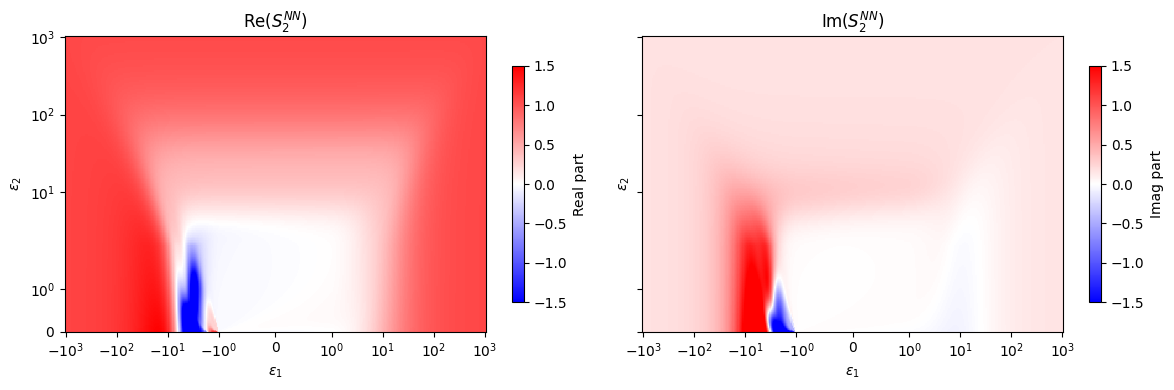

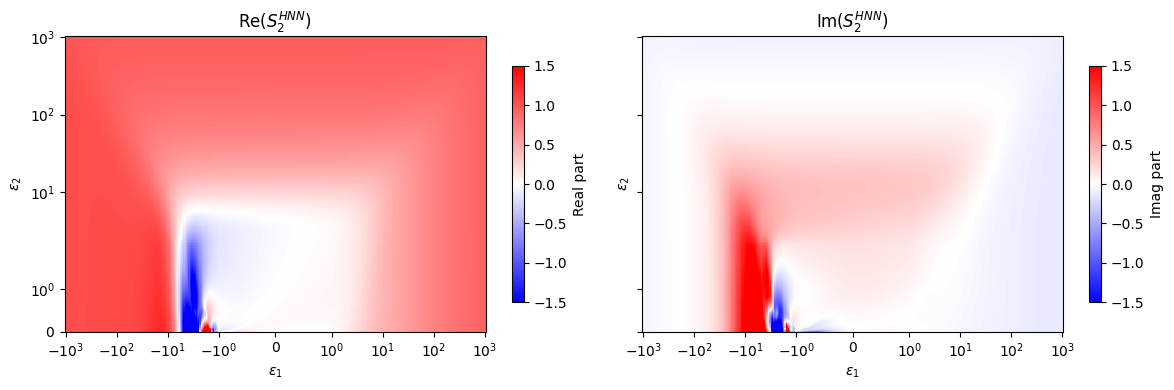

In [43]:
# 4) Plot NN
plot_model_results(Eps1, Eps2, S2_nn_grid,title_prefix="NN")

# 5) Plot HNN
plot_model_results(Eps1, Eps2, S2_hnn_grid,title_prefix="HNN")

Running Differential Evolution (this may take 1-2 minutes)...
differential_evolution step 1: f(x)= 0.19603488045264722
differential_evolution step 2: f(x)= 0.19603488045264722
differential_evolution step 3: f(x)= 0.19603488045264722
differential_evolution step 4: f(x)= 0.19603488045264722
differential_evolution step 5: f(x)= 0.190993574665355
differential_evolution step 6: f(x)= 0.18804252098932153
differential_evolution step 7: f(x)= 0.18804252098932153
differential_evolution step 8: f(x)= 0.18804252098932153
differential_evolution step 9: f(x)= 0.17636860780405092
differential_evolution step 10: f(x)= 0.17636860780405092
differential_evolution step 11: f(x)= 0.17636860780405092
differential_evolution step 12: f(x)= 0.17636860780405092
differential_evolution step 13: f(x)= 0.1713744555443578
differential_evolution step 14: f(x)= 0.1713744555443578
differential_evolution step 15: f(x)= 0.16791556073439723
differential_evolution step 16: f(x)= 0.16708552010963634
differential_evolution 

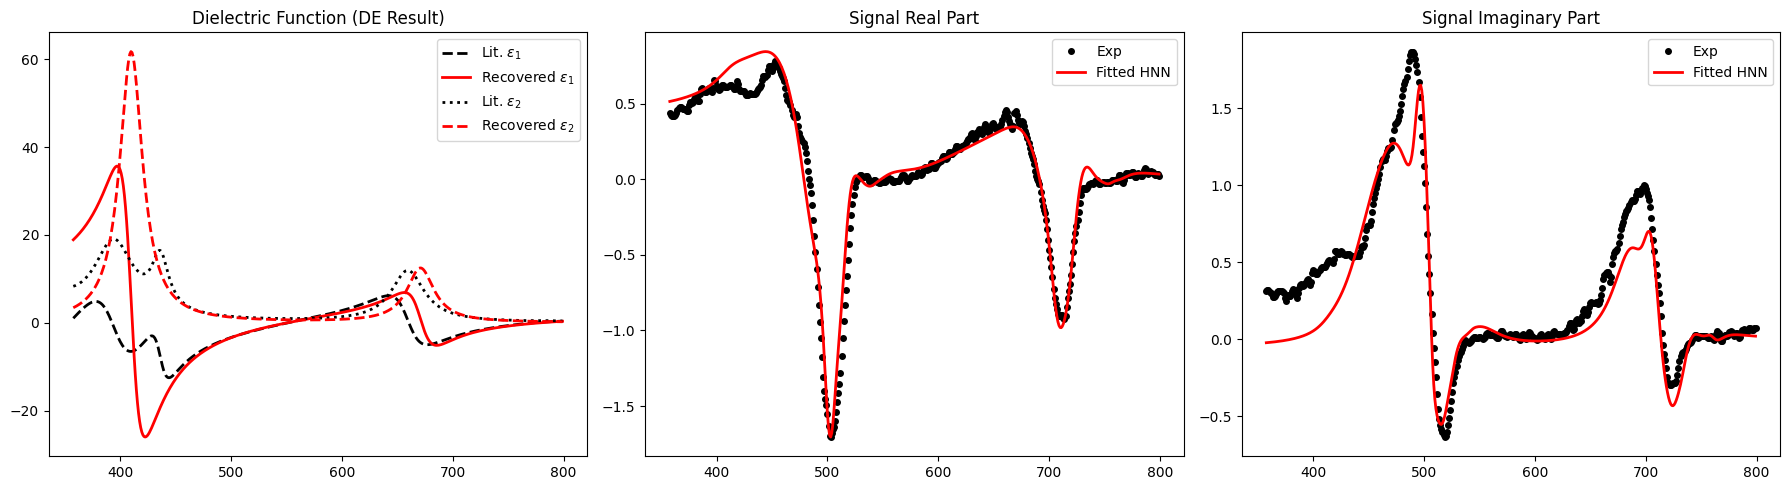

In [101]:
import numpy as np
import torch
from scipy.optimize import differential_evolution
import matplotlib.pyplot as plt

class FastFDM:
    def __init__(self, a=50, L=500, A=68, h0=0, g=0.7*np.exp(0.07*1j), n=2, n_points=30):
        self.a = a
        self.L = L
        self.g = g
        self.n = n
        self.t = np.linspace(0, np.pi, n_points)
        z = A - A*np.cos(self.t) + h0
        
        # Precompute geometry factors (vectorized for speed)
        W_0 = z + 1.31*a
        W_1 = z + a/2
        denom_log = np.log(4*L/a)
        
        self.f0 = (g - (a + z + W_0)/(2*L)) * np.log(4*L/(a + 2*z + 2*W_0)) / denom_log
        self.f1 = (g - (a + z + W_1)/(2*L)) * np.log(4*L/(a + 2*z + 2*W_1)) / denom_log
        
        # Calculate Reference Signal (Au-like) once
        eps_ref = np.array([-10000 + 10000j]) 
        self.s_ref = self._demodulate(self._compute_alpha(eps_ref))

    def _compute_alpha(self, eps):
        # eps shape: (N_freq,) -> beta shape: (N_freq, 1)
        beta = (eps - 1) / (eps + 1)
        beta = beta[:, np.newaxis]
        
        # Broadcast geometry factors: (1, N_time)
        f0_exp = self.f0[np.newaxis, :]
        f1_exp = self.f1[np.newaxis, :]
        
        # Vectorized Alpha calculation
        return beta * f0_exp / (1 - beta * f1_exp)

    def _demodulate(self, alpha_eff):
        # Numerical integration for demodulation
        fourier = np.cos(self.n * self.t)
        return np.trapezoid(alpha_eff * fourier, axis=1)

    def compute_sn(self, f, eps):
        # 1. Near-field signal
        alpha = self._compute_alpha(eps)
        s_samp = self._demodulate(alpha)
        sn_near = s_samp / self.s_ref
        
        # 2. Far-field factor (Vectorized Fresnel)
        n0 = 1.0
        n1 = np.sqrt(eps)
        theta = np.pi/3
        term = np.sqrt(1 - (n0 * np.sin(theta) / n1)**2)
        r_p = (-n0 * term + n1 * np.cos(theta)) / (n0 * term + n1 * np.cos(theta))
        fff = (1 + r_p)**2
        
        return 0.25 * fff * sn_near

# --- 2. Lorentz Model & Objective Function ---

def lorentz_model(f, params):
    # params: [eps_inf, A1, w0_1, gamma_1, A2, w0_2, gamma_2, ...]
    eps_inf = params[0]
    eps = eps_inf + 0j
    num_oscillators = (len(params) - 1) // 3
    for i in range(num_oscillators):

        A = params[1 + i*3]
        w0 = params[2 + i*3]
        gamma = params[3 + i*3]
        eps += (A**2) / (w0**2 - f**2 - 1j * f * gamma)
    return eps

class DielectricInversionDE:
    def __init__(self, model, scaler_X, scaler_y, fast_fdm, device='cpu'):
        self.model = model
        self.scaler_X = scaler_X
        self.scaler_y = scaler_y
        self.fast_fdm = fast_fdm
        self.device = device
        
    def objective(self, params, f_exp, sn_exp_target):
        # 1. Physics: Lorentz -> Epsilon
        eps_pred = lorentz_model(f_exp, params)
        
        # 2. Physics: FDM -> S_FDM (This is the Hybrid part)
        sn_fdm_pred = self.fast_fdm.compute_sn(f_exp, eps_pred)
        
        # 3. ML: Prepare Inputs [beta_re, beta_im, s_fdm_re, s_fdm_im]
        beta_pred = (eps_pred - 1) / (eps_pred + 1)
        features = np.column_stack([
            beta_pred.real, beta_pred.imag, 
            sn_fdm_pred.real, sn_fdm_pred.imag
        ])
        
        # 4. ML: Predict corrected S2
        features_scaled = self.scaler_X.transform(features)
        t_in = torch.tensor(features_scaled, dtype=torch.float32).to(self.device)
        
        with torch.no_grad():
            pred_scaled = self.model(t_in)
            
        pred = self.scaler_y.inverse_transform(pred_scaled.cpu().numpy())
        sn_pred_complex = pred[:, 0] + 1j * pred[:, 1]
        
        # 5. Loss: MSE of complex signal
        mse = np.mean(np.abs(sn_pred_complex - sn_exp_target)**2)
        return mse

# --- 3. Execution: Using Differential Evolution ---
device = 'mps'
# Setup
fast_fdm = FastFDM()
solver = DielectricInversionDE(hnn_model, scaler_X_hnn, scaler_y, fast_fdm, device=device)

# Prepare Data (LSAT)
target_df = final_df[final_df['material'] == 'LSAT']
f_exp = target_df['f'].values
sn_exp = target_df['sn_exp'].values

# Define Bounds (Tuned for LSAT based on your plot)
# Structure: [eps_inf, (A, w0, gamma)_1, (A, w0, gamma)_2]
# We allow a wider search range so it doesn't get stuck.
bounds = [
    (3.0, 4.2),         # eps_inf (usually around 4-5)
    (0.01, 10),          # Osc 1 Strength A
    (300, 480),         # Osc 1 Frequency w0 (Peak 1)
    (5, 100),           # Osc 1 Gamma (Width)
    (0.01, 10),          # Osc 1 Strength A
    (400, 480),         # Osc 1 Frequency w0 (Peak 1)
    (5, 100),           # Osc 1 Gamma (Width)
    (0.01, 10),          # Osc 2 Strength A
    (600, 720),         # Osc 2 Frequency w0 (Peak 2)
    (5, 100),           # Osc 2 Gamma (Width),
    (0.01, 800),          # Osc 3 Strength A
    (0, 2000),         # Osc 3 Frequency w0 (Peak 3)
    (5, 100),            # Osc 3 Gamma (Width)
    (0.01, 800),          # Osc 4 Strength A
    (0, 2000),         # Osc 4 Frequency w0 (Peak 4)
    (5, 100),            # Osc 4 Gamma (Width)
    
]

print("Running Differential Evolution (this may take 1-2 minutes)...")

# Differential Evolution is stochastic and global
result = differential_evolution(
    solver.objective, 
    bounds, 
    args=(f_exp, sn_exp),
    strategy='best1bin', 
    maxiter=200,       # Increase if needed, but 50 is often enough for 2 oscillators
    popsize=15,       # Population size (multiplier of len(params))
    tol=0.01,
    mutation=(0.5, 1), 
    recombination=0.7,
    disp=True         # Print progress
)

print("\nOptimization Complete.")
print("Optimized Parameters:", np.round(result.x, 2))

# --- 4. Plotting the Improvement ---

# Reconstruct result
params_opt = result.x
eps_rec = lorentz_model(f_exp, params_opt)

# Get the HNN fit curve
beta_rec = (eps_rec - 1)/(eps_rec + 1)
sn_fdm_rec = fast_fdm.compute_sn(f_exp, eps_rec)
feats_rec = np.column_stack([beta_rec.real, beta_rec.imag, sn_fdm_rec.real, sn_fdm_rec.imag])
feats_rec_scaled = scaler_X_hnn.transform(feats_rec)
with torch.no_grad():
    pred_scaled = hnn_model(torch.tensor(feats_rec_scaled, dtype=torch.float32).to(device))
pred_final = scaler_y.inverse_transform(pred_scaled.cpu().numpy())
sn_rec_final = pred_final[:, 0] + 1j * pred_final[:, 1]

# Plot
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Epsilon
axes[0].plot(f_exp, target_df['eps1'], 'k--', linewidth=2, label='Lit. $\epsilon_1$')
axes[0].plot(f_exp, eps_rec.real, 'r-', linewidth=2, label='Recovered $\epsilon_1$')
axes[0].plot(f_exp, target_df['eps2'], 'k:', linewidth=2, label='Lit. $\epsilon_2$')
axes[0].plot(f_exp, eps_rec.imag, 'r--', linewidth=2, label='Recovered $\epsilon_2$')
axes[0].set_title('Dielectric Function (DE Result)')
axes[0].legend()

# Real S2
axes[1].plot(f_exp, sn_exp.real, 'ko', markersize=4, label='Exp')
axes[1].plot(f_exp, sn_rec_final.real, 'r-', linewidth=2, label='Fitted HNN')
axes[1].set_title('Signal Real Part')
axes[1].legend()

# Imag S2
axes[2].plot(f_exp, sn_exp.imag, 'ko', markersize=4, label='Exp')
axes[2].plot(f_exp, sn_rec_final.imag, 'r-', linewidth=2, label='Fitted HNN')
axes[2].set_title('Signal Imaginary Part')
axes[2].legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from scipy.optimize import least_squares
import matplotlib.pyplot as plt

# --- 1. Batch-Enabled FastFDM (For rapid training data generation) ---

class BatchFastFDM:
    def __init__(self, f_points, a=50, L=500, A=68, h0=0, g=0.7*np.exp(0.07*1j), n=2, n_points=30):
        self.a = a
        self.L = L
        self.g = g
        self.n = n
        self.f_points = f_points # Fixed frequency grid for training
        
        # Time integration grid
        self.t = np.linspace(0, np.pi, n_points)
        z = A - A*np.cos(self.t) + h0
        
        # Precompute geometry factors (Shape: [1, 1, n_time])
        W_0 = z + 1.31*a
        W_1 = z + a/2
        denom_log = np.log(4*L/a)
        
        f0 = (g - (a + z + W_0)/(2*L)) * np.log(4*L/(a + 2*z + 2*W_0)) / denom_log
        f1 = (g - (a + z + W_1)/(2*L)) * np.log(4*L/(a + 2*z + 2*W_1)) / denom_log
        
        self.f0 = f0[np.newaxis, np.newaxis, :] 
        self.f1 = f1[np.newaxis, np.newaxis, :]
        
        # Reference Signal (Au)
        eps_ref = np.full((1, len(f_points)), -10000 + 10000j)
        self.s_ref = self._compute_signal_batch(eps_ref)

    def _compute_signal_batch(self, eps_batch):
        """
        eps_batch: (Batch_Size, N_Freq)
        Returns: (Batch_Size, N_Freq) complex signal
        """
        # Beta: (Batch, Freq, 1)
        beta = (eps_batch - 1) / (eps_batch + 1)
        beta = beta[:, :, np.newaxis]
        
        # Alpha Effective: (Batch, Freq, Time)
        # Broadcasting: (B, F, 1) * (1, 1, T) -> (B, F, T)
        alpha_eff = beta * self.f0 / (1 - beta * self.f1)
        
        # Demodulate (Trapz over Time axis 2)
        fourier = np.cos(self.n * self.t)[np.newaxis, np.newaxis, :]
        s_near = np.trapezoid(alpha_eff * fourier, axis=2)
        
        return s_near

    def compute_sn_batch(self, eps_batch):
        # 1. Near field
        s_near = self._compute_signal_batch(eps_batch)
        sn_norm = s_near / self.s_ref
        
        # 2. Far Field Factor
        n0 = 1.0
        n1 = np.sqrt(eps_batch)
        theta = np.pi/3
        
        # Fresnel (Batch, Freq)
        term = np.sqrt(1 - (n0 * np.sin(theta) / n1)**2)
        r_p = (-n0 * term + n1 * np.cos(theta)) / (n0 * term + n1 * np.cos(theta))
        fff = (1 + r_p)**2
        
        return 0.25 * fff * sn_norm

# --- 2. Data Generator ---

def generate_training_data(n_samples, f_grid, fdm_solver):
    """
    Generates random Lorentz parameters and corresponding spectra.
    """
    print(f"Generating {n_samples} synthetic spectra...")
    
    # Random Lorentz Parameters
    # Bounds similar to LSAT range
    # [eps_inf, A1, w01, g1, A2, w02, g2]
    
    eps_inf = np.random.uniform(1, 6, n_samples)
    
    # Oscillator 1 (Lower freq)
    A1 = np.random.uniform(50, 600, n_samples)
    w01 = np.random.uniform(350, 500, n_samples)
    g1 = np.random.uniform(5, 50, n_samples)
    
    # Oscillator 2 (Higher freq)
    A2 = np.random.uniform(50, 600, n_samples)
    w02 = np.random.uniform(600, 750, n_samples)
    g2 = np.random.uniform(5, 50, n_samples)
    
    # Stack parameters: Shape (Batch, 7)
    params = np.column_stack([eps_inf, A1, w01, g1, A2, w02, g2])
    
    # Calculate Epsilon
    f_grid_exp = f_grid[np.newaxis, :]
    
    # Vectorized Lorentz calculation
    eps_batch = (eps_inf[:, None] + 
                 (A1[:, None]**2) / (w01[:, None]**2 - f_grid_exp**2 - 1j*f_grid_exp*g1[:, None]) + 
                 (A2[:, None]**2) / (w02[:, None]**2 - f_grid_exp**2 - 1j*f_grid_exp*g2[:, None]))
    
    # Calculate Spectra using BatchFDM
    sn_batch = fdm_solver.compute_sn_batch(eps_batch)
    
    # Add Gaussian Noise (Critical for robustness - Cite: 1107)
    noise_level = 0.02 # 2% noise
    noise = np.random.normal(0, noise_level, sn_batch.shape) + 1j * np.random.normal(0, noise_level, sn_batch.shape)
    sn_batch_noisy = sn_batch + noise
    
    return params, sn_batch_noisy

def generate_training_data_N(n_samples, f_grid, fdm_solver, num_oscillators=9):
    print(f"Generating {n_samples} synthetic spectra for {num_oscillators} oscillators...")
    
    # 1. Generate Eps Inf
    eps_inf = np.random.uniform(2.0, 5.0, (n_samples, 1))
    
    # 2. Generate Oscillators (Amplitudes, Frequencies, Damping)
    # We generate them all at once
    A_all = np.random.uniform(1.0, 600.0, (n_samples, num_oscillators))
    w0_all = np.random.uniform(100.0, 800.0, (n_samples, num_oscillators))
    g_all = np.random.uniform(5.0, 80.0, (n_samples, num_oscillators))
    
    # CRITICAL FIX: Sort oscillators by frequency (w0) for each sample
    # This prevents the CNN permutation problem.
    sort_indices = np.argsort(w0_all, axis=1)
    
    # Apply the sorting to A, w0, and g using advanced indexing
    row_indices = np.arange(n_samples)[:, np.newaxis]
    A_sorted = A_all[row_indices, sort_indices]
    w0_sorted = w0_all[row_indices, sort_indices]
    g_sorted = g_all[row_indices, sort_indices]
    
    # Interleave the parameters: [eps_inf, A1, w01, g1, A2, w02, g2, ...]
    params_list = [eps_inf]
    for i in range(num_oscillators):
        params_list.append(A_sorted[:, i:i+1])
        params_list.append(w0_sorted[:, i:i+1])
        params_list.append(g_sorted[:, i:i+1])
        
    params = np.column_stack(params_list) # Final Shape: (Batch, 1 + 3*N)
    
    # 3. Vectorized Epsilon Calculation
    f_grid_exp = f_grid[np.newaxis, :]
    eps_batch = eps_inf + 0j
    
    for i in range(num_oscillators):
        A = A_sorted[:, i:i+1]
        w0 = w0_sorted[:, i:i+1]
        g = g_sorted[:, i:i+1]
        eps_batch += (A**2) / (w0**2 - f_grid_exp**2 - 1j*f_grid_exp*g)
        
    # 4. Compute Signals
    sn_batch = fdm_solver.compute_sn_batch(eps_batch)
    
    # Add Gaussian Noise
    noise_level = 0.02
    noise = np.random.normal(0, noise_level, sn_batch.shape) + 1j * np.random.normal(0, noise_level, sn_batch.shape)
    sn_batch_noisy = sn_batch + noise
    
    return params, sn_batch_noisy

In [29]:
class InverseCNN(nn.Module):
    def __init__(self, num_freq_points, num_output_params=7):
        super(InverseCNN, self).__init__()
        
        # Conv1D Layers (Feature Extraction)
        # Input: (Batch, 2, N_Freq) -> 2 channels: Real & Imag
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=64, kernel_size=25, padding=12)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=15, padding=7)
        self.conv3 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        
        # Calculate flattened size
        # With padding=same (approx), length remains num_freq_points
        self.flat_size = 256 * num_freq_points
        
        # Dense Layers (Regression)
        self.fc1 = nn.Linear(self.flat_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.output = nn.Linear(128, num_output_params)
        
    def forward(self, x):
        # x shape: (Batch, 2, N_Freq)
        
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        
        x = self.flatten(x)
        
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        
        out = self.output(x) # Predicted Parameters
        return out

Using computational device: mps
Generating 5000 synthetic spectra...
Training Inverse CNN...
Epoch 1/50: Loss = 0.54246 | Time: 7.22s
Epoch 2/50: Loss = 0.23060 | Time: 7.19s
Epoch 3/50: Loss = 0.15706 | Time: 7.29s
Epoch 4/50: Loss = 0.13003 | Time: 7.30s
Epoch 5/50: Loss = 0.11101 | Time: 7.21s
Epoch 6/50: Loss = 0.09758 | Time: 7.15s
Epoch 7/50: Loss = 0.09421 | Time: 7.24s
Epoch 8/50: Loss = 0.08228 | Time: 7.10s
Epoch 9/50: Loss = 0.07719 | Time: 7.11s
Epoch 10/50: Loss = 0.07267 | Time: 7.12s
Epoch 11/50: Loss = 0.06696 | Time: 7.26s
Epoch 12/50: Loss = 0.06314 | Time: 7.44s
Epoch 13/50: Loss = 0.06149 | Time: 7.24s
Epoch 14/50: Loss = 0.05749 | Time: 7.35s
Epoch 15/50: Loss = 0.05530 | Time: 7.32s
Epoch 16/50: Loss = 0.05350 | Time: 7.66s
Epoch 17/50: Loss = 0.05113 | Time: 8.09s
Epoch 18/50: Loss = 0.05013 | Time: 7.57s
Epoch 19/50: Loss = 0.04637 | Time: 7.79s
Epoch 20/50: Loss = 0.04578 | Time: 8.08s
Training Complete in 2.46 minutes!


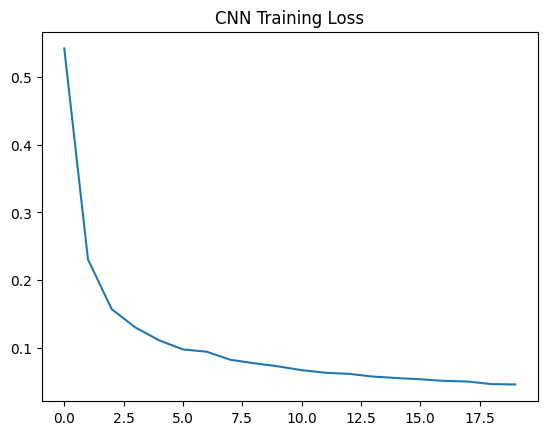

CNN Raw Initial Guess: [   4.98 1044.43  379.48   23.7   618.61  664.59   28.09]
Clipped Initial Guess: [  4.98 100.   379.48  23.7  100.   664.59  28.09]
Refining with Trust Region Reflective (TRM)...
`ftol` termination condition is satisfied.
Function evaluations 40, initial cost 1.3645e+02, final cost 1.3046e+02, first-order optimality 1.36e-01.
Final Refined Parameters: [  3.16 100.   485.54   1.53 100.   490.04   3.15]


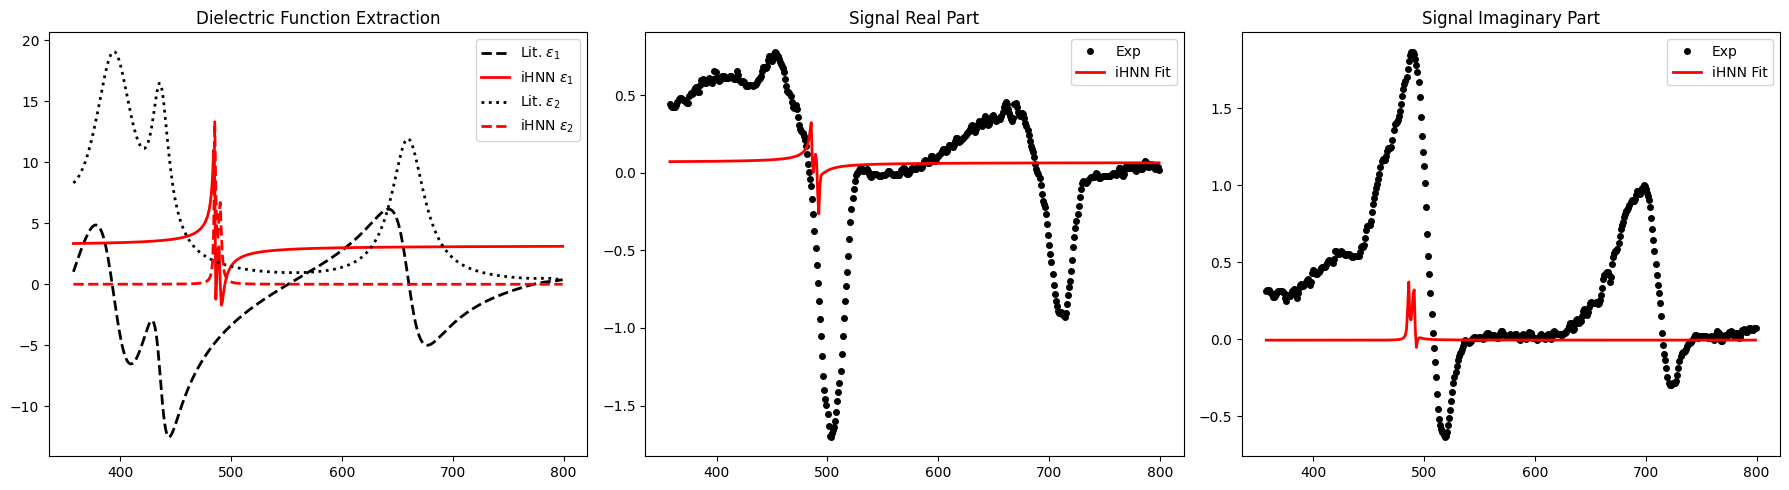

In [103]:
# --- Setup ---
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import time

# Enable Hardware Acceleration for Apple Silicon
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
print(f"Using computational device: {device}")

# 1. Prepare Data
# We use the frequency grid from your LSAT data
target_df = final_df[final_df['material'] == 'LSAT']
f_exp = target_df['f'].values
sn_exp = target_df['sn_exp'].values
N_FREQ = len(f_exp)

# Initialize Batch Solver
batch_fdm = BatchFastFDM(f_exp)

# Generate Training Data (e.g., 5000 samples for demo)
# The paper recommends millions, but 5000 is enough for a proof-of-concept
N_SAMPLES = 5000 
y_params, X_spectra = generate_training_data(N_SAMPLES, f_exp, batch_fdm)

# Prepare Tensors
# X Input: (Batch, 2, N_Freq) -> Stack Real and Imag
X_real = np.real(X_spectra)
X_imag = np.imag(X_spectra)
X_tensor = torch.tensor(np.stack([X_real, X_imag], axis=1), dtype=torch.float32).to(device)

# Y Output: Parameters (Standardized)
scaler_params = torch.tensor(np.mean(y_params, axis=0), dtype=torch.float32).to(device)
std_params = torch.tensor(np.std(y_params, axis=0), dtype=torch.float32).to(device)
y_tensor = (torch.tensor(y_params, dtype=torch.float32).to(device) - scaler_params) / std_params

# Dataset
dataset = TensorDataset(X_tensor, y_tensor)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- 2. Train CNN ---

model = InverseCNN(num_freq_points=N_FREQ).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-4) # Learning rate from paper [cite: 992]
criterion = nn.MSELoss()

print("Training Inverse CNN...")
total_start_time = time.time()
loss_history = []
for epoch in range(20): # 50 epochs
    epoch_start_time = time.time()
    model.train()
    running_loss = 0.0
    for inputs, targets in loader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    avg_loss = running_loss / len(loader)
    loss_history.append(avg_loss)
    epoch_duration = time.time() - epoch_start_time
    print(f"Epoch {epoch+1}/50: Loss = {avg_loss:.5f} | Time: {epoch_duration:.2f}s")
    # if epoch % 10 == 0:
    #     print(f"Epoch {epoch}: Loss = {avg_loss:.5f}")

total_duration = time.time() - total_start_time
print(f"Training Complete in {total_duration/60:.2f} minutes!")

plt.plot(loss_history)
plt.title("CNN Training Loss")
plt.show()

# --- 3. The iHNN Solver (Inference + Refinement) ---
def ihnn_solve(model, f_exp, sn_exp, scaler_mean, scaler_std):
    
    # A. CNN Prediction (Initial Guess)
    model.eval()
    
    # Prepare Input
    x_in = np.stack([sn_exp.real, sn_exp.imag], axis=0) # (2, N_Freq)
    x_in = x_in[np.newaxis, :, :] # (1, 2, N_Freq)
    x_tensor = torch.tensor(x_in, dtype=torch.float32).to(device)
    
    with torch.no_grad():
        pred_norm = model(x_tensor)
    
    # Denormalize parameters
    params_guess = (pred_norm * scaler_std + scaler_mean).cpu().numpy().flatten()
    print(f"CNN Raw Initial Guess: {np.round(params_guess, 2)}")
    
    # B. TRM / Least Squares Refinement
    def residuals(params):
        # 1. Physics: Lorentz -> Eps
        eps = lorentz_model(f_exp, params)
        # 2. Physics: FastFDM -> Sn
        eps_b = eps[np.newaxis, :]
        sn_pred = batch_fdm.compute_sn_batch(eps_b)[0]
        
        # Residual vector (Real + Imag concatenated)
        res = np.concatenate([sn_pred.real - sn_exp.real, 
                              sn_pred.imag - sn_exp.imag])
        return res

    # Defined Bounds (slightly widened to be safe)
    lower_bounds = np.array([1.0, 0.01, 50.0, 1.0, 0.01, 400.0, 1.0])
    upper_bounds = np.array([10.0, 100.0, 550.0, 150.0, 100.0, 800.0, 150.0])
    
    # Force the CNN guess to strictly fall within the bounds
    # (Adding a tiny 1e-5 margin prevents Scipy edge-case errors)
    params_guess_clipped = np.clip(params_guess, lower_bounds + 1e-5, upper_bounds - 1e-5)
    print(f"Clipped Initial Guess: {np.round(params_guess_clipped, 2)}")
    
    print("Refining with Trust Region Reflective (TRM)...")
    res_opt = least_squares(residuals, params_guess_clipped, bounds=(lower_bounds, upper_bounds), 
                            method='trf', loss='linear', verbose=1)
    
    return params_guess_clipped, res_opt.x

# Run Solver on LSAT Data
params_cnn, params_refined = ihnn_solve(model, f_exp, sn_exp, scaler_params, std_params)

print("Final Refined Parameters:", np.round(params_refined, 2))

# --- 4. Plot Final Result ---
def lorentz_model_np(f, params):
    # Standard non-batch Lorentz for plotting
    eps_inf = params[0]
    A1, w01, g1 = params[1], params[2], params[3]
    A2, w02, g2 = params[4], params[5], params[6]
    return eps_inf + A1**2/(w01**2 - f**2 - 1j*f*g1) + A2**2/(w02**2 - f**2 - 1j*f*g2)

eps_final = lorentz_model_np(f_exp, params_refined)
sn_final = batch_fdm.compute_sn_batch(eps_final[np.newaxis, :])[0]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Epsilon
axes[0].plot(f_exp, target_df['eps1'], 'k--', linewidth=2, label='Lit. $\epsilon_1$')
axes[0].plot(f_exp, eps_final.real, 'r-', linewidth=2, label='iHNN $\epsilon_1$')
axes[0].plot(f_exp, target_df['eps2'], 'k:', linewidth=2, label='Lit. $\epsilon_2$')
axes[0].plot(f_exp, eps_final.imag, 'r--', linewidth=2, label='iHNN $\epsilon_2$')
axes[0].set_title('Dielectric Function Extraction')
axes[0].legend()

# Real Signal
axes[1].plot(f_exp, sn_exp.real, 'ko', markersize=4, label='Exp')
axes[1].plot(f_exp, sn_final.real, 'r-', linewidth=2, label='iHNN Fit')
axes[1].set_title('Signal Real Part')
axes[1].legend()

# Imag Signal
axes[2].plot(f_exp, sn_exp.imag, 'ko', markersize=4, label='Exp')
axes[2].plot(f_exp, sn_final.imag, 'r-', linewidth=2, label='iHNN Fit')
axes[2].set_title('Signal Imaginary Part')
axes[2].legend()

plt.tight_layout()
plt.show()